## Data Source

* The data source is the file `train.csv`.
* These are 28x28 pixel grayscale images obtained from the [Fashion MNIST dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
* The file `train.csv` contains the training data.
* The target (explained) variable is named **label**.

## Project Content

* In the notebook, we will load the data from the file `train.csv`. We will appropriately split the data into subsets for training, model comparison, and subsequent prediction of the final model's performance.
* Perform basic data exploration.
* Apply the **SVM**, **naive Bayes classifier**, and **LDA** models step by step, where for each:
    * Select the main hyperparameters to tune (if the model has hyperparameters) and find their best values.
    * Experiment with data standardization/normalization.
    * For SVM, try at least two different kernel functions.

* Apply dimensionality reduction methods PCA and LLE step by step, where for each:
    * Repeat the previous steps and attempt to improve the models.
    * Determine which dimension is optimal in terms of the final model's performance.

* From all the options tested, select the final model and estimate the expected accuracy on new data that we have not yet had access to.

In [528]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.reset_orig()

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.manifold import LocallyLinearEmbedding 

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import sklearn.metrics as metrics

random_seed = 68776753

In [529]:
# Define colors with RGBA format
color_map = {
    "Orig":                               'rgba(255, 165, 0, 0.5)',      # Orange
    "Std_Scaled":                         'rgba(255, 0, 255, 0.5)',      # Magenta
    "MinMax_Scaled":                      'rgba(255, 0, 255, 0.5)',      # Magenta
    "Orig_PCA":                           'rgba(238, 130, 238, 0.5)',    # Violet
    "Orig_LLE":                           'rgba(255, 0, 0, 0.5)',        # Red
    "Std_Scaled_PCA":                     'rgba(0, 128, 0, 0.5)',        # Green
    "Std_Scaled_LLE":                     'rgba(0, 0, 255, 0.5)',        # Blue
    "MinMax_Scaled_PCA":                  'rgba(0, 128, 0, 0.5)',        # Green
    "MinMax_Scaled_LLE":                  'rgba(0, 0, 255, 0.5)',        # Blue
    "Orig_PCA_Std_Scaled":                'rgba(39, 116, 174, 0.5)',     # Hex color converted to RGBA
    "Orig_LLE_Std_Scaled":                'rgba(128, 0, 128, 0.5)',      # Purple
    "Orig_PCA_MinMax_Scaled":             'rgba(39, 116, 174, 0.5)',     # Hex color converted to RGBA
    "Orig_LLE_MinMax_Scaled":             'rgba(128, 0, 128, 0.5)',      # Purple
    "Std_Scaled_PCA_Std_Scaled":          'rgba(0, 0, 0, 0.5)',          # Black
    "Std_Scaled_LLE_Std_Scaled":          'rgba(0, 255, 255, 0.5)',      # Cyan
    "MinMax_Scaled_PCA_MinMax_Scaled":    'rgba(0, 0, 0, 0.5)',          # Black
    "MinMax_Scaled_LLE_MinMax_Scaled":    'rgba(0, 255, 255, 0.5)',      # Cyan
}


## Data Collection 

In [530]:
data = pd.read_csv("train.csv")
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,208,122,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,75,11,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,106,103,76,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0,0,0,0,0,0,0,0,0,0,...,63,0,0,0,0,0,0,0,0,0
2396,1,0,0,0,0,0,0,0,1,0,...,91,24,0,0,0,0,0,0,0,0
2397,1,0,0,0,0,0,0,0,0,0,...,66,111,25,0,0,0,0,0,0,0
2398,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Description of dataset from Kaggle:

### About Dataset

#### Context
- Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

#### Content
- Each image is **28 pixels in height and 28 pixels in width**, for a total of **784 pixels in total**. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between **0 and 255**[^1]. The training and test data sets have **785 columns**. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

- To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix[^2].
- For example, **pixel31** indicates the pixel that is in the **fourth column** from the left, and the **second row** from the top.


#### Labels

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot


TL;DR

- Each row is a separate image
- Column 1 is the class label.
- Remaining columns are pixel numbers (784 total).
- Each value is the darkness of the pixel (0 to 255)

[^1]: *(author's notes: apparently value scales from 0 to 255 where 0 is black and 255 is white)*

[^2]: *(author's notes: apparently the bounds for j are incorrectly specified. There is no pixel0 in the dataset, and if i and j take values from 0 to 27, the total number of pixels is 27\*28+27 = 783. In this paper I assume that j takes values from 1 to 28)*

###
Let's see some basic information available:

In [531]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 785 columns):
 #    Column    Dtype
---   ------    -----
 0    label     int64
 1    pixel1    int64
 2    pixel2    int64
 3    pixel3    int64
 4    pixel4    int64
 5    pixel5    int64
 6    pixel6    int64
 7    pixel7    int64
 8    pixel8    int64
 9    pixel9    int64
 10   pixel10   int64
 11   pixel11   int64
 12   pixel12   int64
 13   pixel13   int64
 14   pixel14   int64
 15   pixel15   int64
 16   pixel16   int64
 17   pixel17   int64
 18   pixel18   int64
 19   pixel19   int64
 20   pixel20   int64
 21   pixel21   int64
 22   pixel22   int64
 23   pixel23   int64
 24   pixel24   int64
 25   pixel25   int64
 26   pixel26   int64
 27   pixel27   int64
 28   pixel28   int64
 29   pixel29   int64
 30   pixel30   int64
 31   pixel31   int64
 32   pixel32   int64
 33   pixel33   int64
 34   pixel34   int64
 35   pixel35   int64
 36   pixel36   int64
 37   pixel37   int64
 38   pixel3

- We have 2400 pictures in total.
- The memory usage is pretty decent - 14 MB.

In [532]:
data.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,2400.000000,2400.0,2400.0,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.00000,2400.000000,2400.000000,2400.0
mean,0.484167,0.0,0.0,0.0,0.002083,0.098333,0.302500,0.846250,2.256250,6.025000,...,65.379583,26.975417,9.651667,3.307500,1.249167,0.460417,0.11250,0.038750,0.010833,0.0
std,0.499853,0.0,0.0,0.0,0.067682,1.895871,5.014792,9.262155,15.491603,25.358871,...,66.874570,49.060424,30.540885,18.067668,11.443957,6.363199,2.82043,1.742655,0.530723,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
75%,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,114.250000,35.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
max,1.000000,0.0,0.0,0.0,3.000000,69.000000,188.000000,189.000000,219.000000,243.000000,...,248.000000,252.000000,246.000000,212.000000,179.000000,176.000000,88.00000,85.000000,26.000000,0.0


- Here we can see that maximum value of target **label** is 1, which does not corresponds with description from Kaggle.
- Also it seems that **pixel1, pixel2** and **pixel3** have value 0 for all pictures, which means that their color is always black. Therefore they have **almost no impact** on target.

## Data Split

In [533]:
# Split ratio: 70% train, 30% test

Xtrain, Xtest, ytrain, ytest = train_test_split( 
      data.drop(columns=['label']), 
      data['label'], 
      test_size=0.3, 
      random_state=random_seed
)

print(Xtrain.shape)
print(Xtest.shape)

(1680, 784)
(720, 784)


## Data Exploration

First of all lets make sure we dont have missing values:

In [534]:
missing_values = Xtrain.isna().any().any()
non_integer_values = Xtrain.applymap(lambda x: not isinstance(x, int)).any().any()
print(f"Presence of missing values: {missing_values and non_integer_values}")

Presence of missing values: False


Let's observe how many unique labels we have:

In [535]:
ytrain.unique()

array([0, 1], dtype=int64)

It seems that target have only 2 possible values - trousers(0) or non-trousers(1):

In [536]:
# Define label names
label_names = {
    0: 'Trouser',
    1: 'Non-Trouser'
}

To ensure that my mapping is correct, let's display examples of pictures:

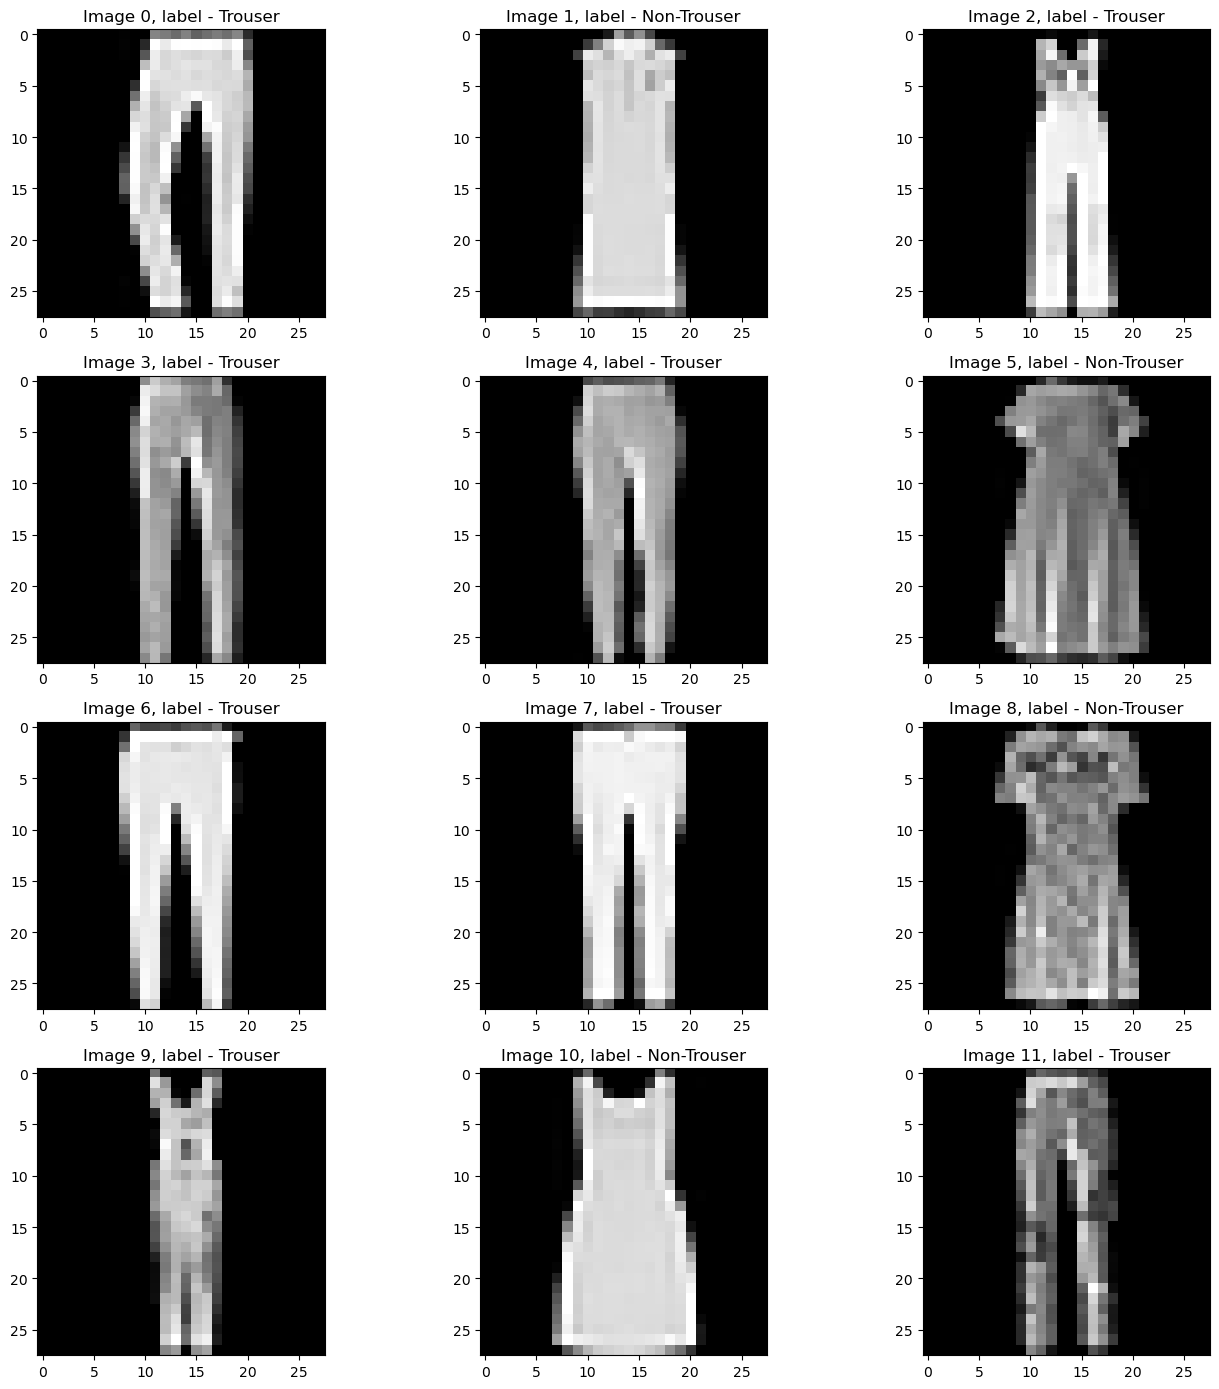

In [537]:
# Number of images to display
num_images = 12 

# Calculate the number of rows and columns for subplots
num_rows = (num_images + 2) // 3  # Ensure at least 3 images per row
num_cols = min(num_images, 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Let's plot several images on a separate subplot
for img_index in range(num_images):
    img = Xtrain.iloc[img_index].values.reshape((28,28))
    row_index = img_index // num_cols
    col_index = img_index % num_cols
    axes[row_index,col_index].imshow(img, cmap='gray',vmin=0,vmax=255)
    axes[row_index,col_index].set_title(f'Image {img_index}, label - {label_names[ytrain.iloc[img_index]]}')  # Add title to each subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Now let's see how much data we have for each type of label:

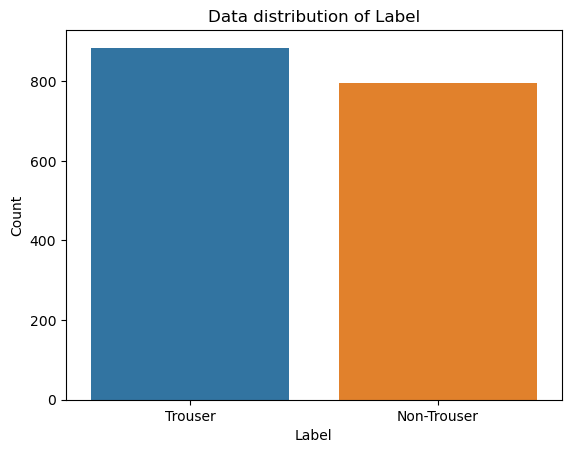

In [538]:
sns.countplot(x=ytrain.map(label_names))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Data distribution of Label')
plt.show()

It seems that we have almost equal amount of trousers and non-trousers - which is good.

Now let's try to plot histograms for every pixel and see what values they take across all pictures in train set:

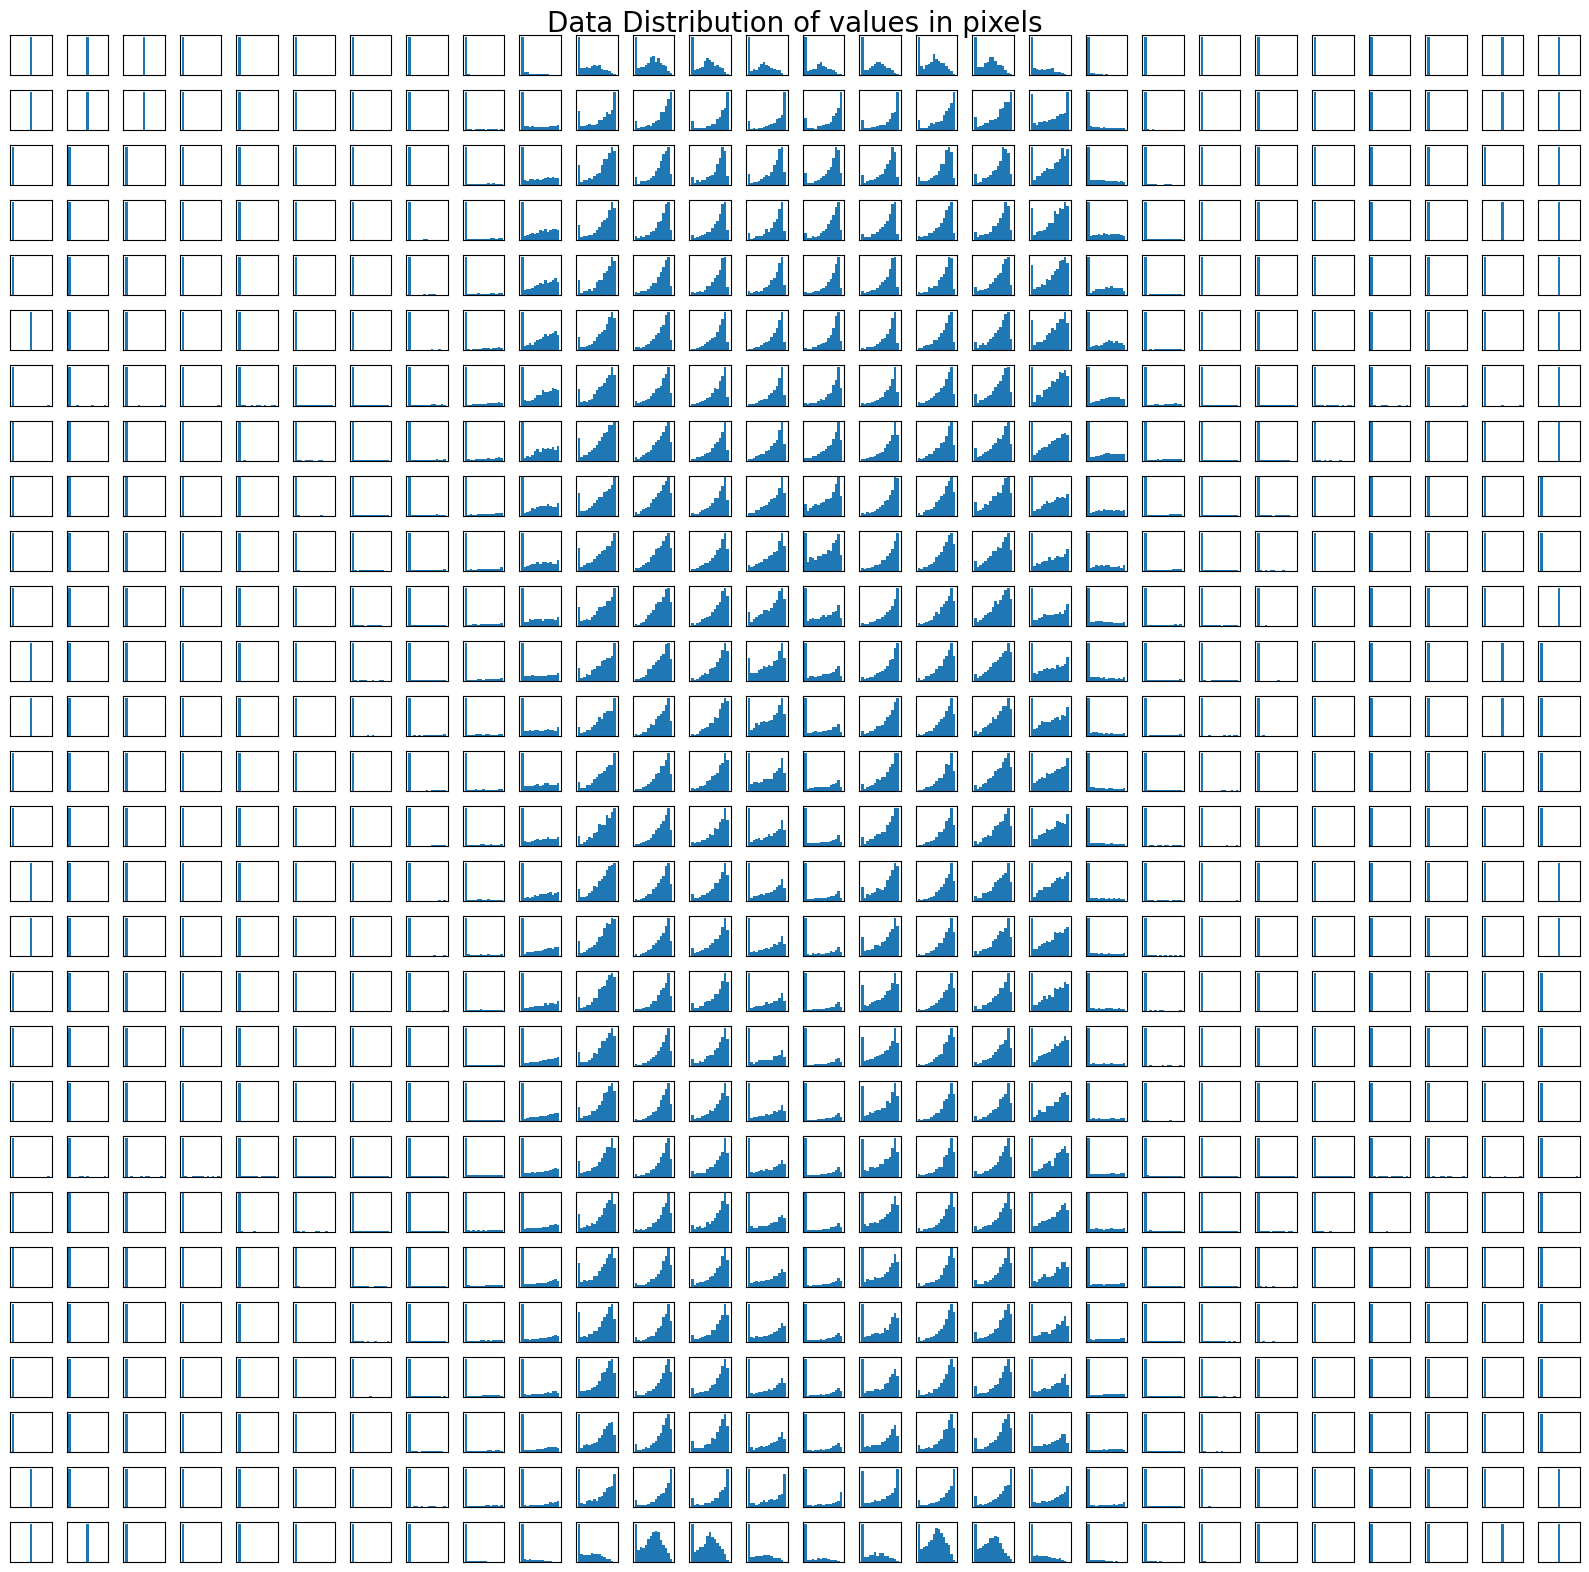

In [539]:
axes = Xtrain.hist(bins=15, figsize=(16,16))
for ax in axes.flatten():
      ax.set_xticks([])
      ax.set_yticks([])
      ax.tick_params(axis='both', which='both', length=0)
      ax.set_title("")

plt.suptitle("Data Distribution of values in pixels",fontsize=20)
plt.tight_layout()
plt.show()

It seems that pixels in central columns (10-20) contain basic information about the image. All other take mostly the same value of darkness.

## Models

### Original dataset

#### Support Vector Machine (SVM)

Support Vector Machine (SVM) is a popular supervised learning algorithm used for classification tasks, making it suitable for the given task of classifying fashion items based on image data.

**Pros:**
1. **Effective in High-Dimensional Spaces**: SVM performs well in high-dimensional spaces, which is relevant for image data represented as high-dimensional pixel values. In this case, each image is represented by 784 pixel values, making SVM an appropriate choice.

2. **Robust to Overfitting**: SVM is less prone to overfitting compared to other algorithms, especially when using appropriate regularization parameters. This is beneficial for handling the complexity of image data and avoiding model overfitting.

3. **Effective with Nonlinear Data**: SVM can efficiently handle nonlinear decision boundaries through the use of kernel functions. By transforming the input space into a higher-dimensional space, SVM can effectively classify nonlinear patterns in the data.

4. **Binary Classification**: SVM inherently performs binary classification, which matches the task requirement of recognizing (classifying) trousers in fashion clothes.

5. **Memory Efficiency**: SVM only requires a subset of training data points (support vectors) to define the decision boundary, making it memory efficient, especially for large datasets like Fashion-MNIST with 60,000 training examples (we have reduced dataset though).

**Cons:**

1. **Computationally Intensive**: Training an SVM model can be computationally intensive, especially for large datasets, as it involves solving a quadratic programming problem.

2. **Sensitivity to Parameter Tuning**: SVM performance is sensitive to the choice of hyperparameters such as the regularization parameter ($C$) and the kernel parameters (e.g., gamma for the RBF kernel, degree for the polynomial kernel).

3. **Limited Interpretability**: The decision boundary learned by SVM may be difficult to interpret, especially in high-dimensional spaces or when using complex kernel functions.

4. **Need for Feature Scaling**: SVM performance can be affected by the scale of features, so it often requires feature scaling (e.g., normalization or standardization) before training.

There are several hyperparameters available: $C$, $\gamma$, $degree$, $kernel$

- The $C$ parameter trades off correct classification of training examples against maximization of the decision function’s margin.
  - For larger values of $C$, a smaller margin will be accepted if the decision function is better at classifying all training points correctly.
  - A lower $C$ will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy.

- Intuitively, the $\gamma$ parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
  - If $\gamma$ is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.
  - When $\gamma$ is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set.

- The $degree$ parameter is used when the kernel is set to polynomial, it controls the degree of the polynomial function.

- The $kernel$ parametr specifies the kernel type to be used in the algorithm.

Let's make grid of hyperparameters:

In [540]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

svm = SVC(cache_size=1000)

param_grid_poly = {
          "C": np.logspace(-3, 3, num=7, base=10),
          "gamma": np.logspace(-3, 3, num=7, base=10),
          "degree": [2, 3, 4, 5],
          "kernel":['poly'],
          "max_iter":[1000000]
}

grid_search_poly = GridSearchCV(estimator=svm, param_grid=param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(Xtrain, ytrain)


best_params_poly = grid_search_poly.best_params_
best_score_poly = grid_search_poly.best_score_

print(f"We found the best params for poly kernel {best_params_poly}\nWith cross-validation accuracy {best_score_poly:.5f}.")

We found the best params for poly kernel {'C': 0.001, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'max_iter': 1000000}
With cross-validation accuracy 0.97381.


In [541]:

svm = SVC(cache_size=1000)

param_grid_rbf = {
          "C": np.logspace(-3, 3, num=7, base=10),
          "gamma": np.logspace(-11, 4, num=16, base=10),
          "kernel":['rbf']
}

grid_search_rbf = GridSearchCV(estimator=svm, param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(Xtrain, ytrain)

best_params_rbf = grid_search_rbf.best_params_
best_score_rbf = grid_search_rbf.best_score_

print(f"We found the best params for rbf kernel {best_params_rbf}\nWith cross-validation accuracy {best_score_rbf:.5f}.")

We found the best params for rbf kernel {'C': 10.0, 'gamma': 1e-07, 'kernel': 'rbf'}
With cross-validation accuracy 0.97500.


In [619]:
svm_sigm = SVC(cache_size=1000)

param_grid_sigm = {
    "C": np.logspace(-3, 3, num=7, base=10),
    "gamma": np.logspace(-11, 4, num=16, base=10),
    "kernel": ['sigmoid']
}

grid_search_sigm = GridSearchCV(estimator=svm_sigm, param_grid=param_grid_sigm, cv=5, scoring='accuracy')
grid_search_sigm.fit(Xtrain, ytrain)
best_params_sigm = grid_search_sigm.best_params_
best_score_sigm = grid_search_sigm.best_score_

print(f"We found the best params for sigmoid kernel {best_params_sigm}\nWith cross-validation accuracy {best_score_sigm:.5f}.")

We found the best params for sigmoid kernel {'C': 100.0, 'gamma': 1e-08, 'kernel': 'sigmoid'}
With cross-validation accuracy 0.97083.


Here we can see that rbf kernel has the best accuracy - 0.975. But parameter $\gamma$ is really small, which indicates that the region of influence of any selected support vector would include the whole training set.
- We can fix that by standartization/normalization of dataset (this was also suggested by warnings I have hidden: "ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler").

But first let's take a look at naive Bayes classifier:

#### Naive Bayes classifier

**Pros:**

1. **Simple and Fast:** Naive Bayes is a simple and fast algorithm. It is easy to implement and requires less computational resources compared to more complex models. This makes it suitable for MNIST dataset.

2. **Efficient with High-Dimensional Data:** Naive Bayes performs well with high-dimensional data, such as text classification or document categorization, where the number of features is large compared to the number of instances.

3. **Handles Missing Data:** Naive Bayes can handle missing values in the dataset. It uses the available data to make predictions and does not require imputation of missing values.

4. **Good with Categorical Features:** Naive Bayes works well with categorical features. It can handle both categorical and numerical features in the dataset.

5. **Interpretable:** The probabilistic nature of Naive Bayes makes it easy to interpret the model's predictions. It provides probabilities for each class, allowing understanding of the confidence of the predictions.

**Cons:**

1. **Assumption of Independence:** Naive Bayes assumes that all features are conditionally independent given the class label. In reality, this assumption may not hold true for many real-world datasets (our dataset is most likely among those real-world datasets). Violations of this assumption can lead to suboptimal performance.

2. **Sensitivity to Feature Correlations:** Due to its assumption of feature independence, Naive Bayes may perform poorly when features are highly correlated. For example, the pixel intensity values are correlated within each image, and neighboring pixels are likely to have dependencies. In such cases, the model may overlook important relationships between features, leading to inaccurate predictions.

3. **Limited Expressiveness:** Naive Bayes has limited expressiveness compared to more complex models such as decision trees or neural networks. It may not capture complex relationships in the data, especially when interactions between features are important for the classification task.

4. **Zero Probability Issue:** Naive Bayes can encounter the "zero probability" issue when a categorical feature value appears in the test set but not in the training set. This can lead to zero probabilities for certain classes, affecting the model's predictions.

5. **Requires Large Training Data:** Naive Bayes performs best with a large amount of training data. With small datasets, it may suffer from poor generalization and high variance.

We can have a different look at the pixels value: They are either continious or discrete (can take values in range(256)). Therefore, we can apply several Bayes classificators

Starting with **GaussianNB**,  the Gaussian Naive Bayes algorithm for classification. It is used for continious features. Unlike the other models, this one has no hyperparameters for tuning:

In [543]:
gaus_nb = GaussianNB()
gaus_nb.fit(Xtrain,ytrain)
scores_gaus_nb = cross_val_score(gaus_nb, Xtrain, ytrain, cv=5)
print(f"Cross-validation accuracy is {scores_gaus_nb.mean():.5f} with a standard deviation of {scores_gaus_nb.std():.5f}")

Cross-validation accuracy is 0.75119 with a standard deviation of 0.14049


It seems that we need to try discrete look.

One option is to use **MultinomialNB** - the multinomial Naive Bayes classifier, suitable for classification with discrete features. It assumes that the data follow Multinomial distribution, where each feature $X_j$ has value, representing number of occurrences. The model for conditional probability is 

$$P(\boldsymbol X = \boldsymbol x | Y = y) = \frac{n!}{\prod_{i = 1}^p x_i!}\prod_{j = 1}^p p_{j,y}^{x_j}$$
Where: 
- $n = \sum_{i = 1}^p x_i$ is the number of pixels on the given photo,
- $p_{j, y}$ - probability of pixel $j$ on photo of group $y$ to be colored

It has one parameter to tune - $\alpha$. This parameter is introduced to handle the zero-frequency problem.

The simplest estimate of $p_{j, y}$ is the ratio of the number of occurrences of the j-th pixel in all photos of a given category divided by the total length of all photos of that category,

$$ \hat{p}_{j,y} = \frac{N_{j,y}}{N_y} $$

The parameters $ \hat{p}_{j,y} $ are estimated by a smoothed version of maximum likelihood:

$$ \hat{p}_{j,y} = \frac{N_{j,y} + \alpha}{N_y + \alpha|V|} $$

Where:
- $N_{j,y} = \sum_{i=1}^{N} x_{i,j}$ is the number of times pixel $j$ appears to be colored on a photo of class $y$ in the training set,
- $x_{i,j}$ is the value of shade of the j-th pixel on the i-th photo,
- $N_{y} = \sum_{j=1}^{D} N_{j,y}$ is the total count of all pixels for class $y$,
- $ |V| $ is the total number of pixels in the training data,
- $ \alpha $ is the Laplace smoothing parameter.

In [544]:
multi_nb = MultinomialNB()
param_grid = {
      'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
      }

grid_search_multi = GridSearchCV(estimator=multi_nb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_multi.fit(Xtrain, ytrain)

best_params_multi = grid_search_multi.best_params_
best_score_multi = grid_search_multi.best_score_

print(f"We found the best params for MultinomialNB {best_params_multi}\nWith cross-validation accuracy {best_score_multi:.5f}.")

We found the best params for MultinomialNB {'alpha': 0.1}
With cross-validation accuracy 0.93571.


Much better result

There is better version of the prevoius model - **ComplementNB**, complement naive Bayes (CNB) algorithm. From scikit-learn:

```CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm. It was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets. ```

Like MultinomialNB, this model has parameter $\alpha$. Let's tune it:

In [545]:
compl_nb = ComplementNB()
param_grid = {
      'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
      }

grid_search_compl = GridSearchCV(estimator=compl_nb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_compl.fit(Xtrain, ytrain)

best_params_compl = grid_search_compl.best_params_
best_score_compl = grid_search_compl.best_score_

print(f"We found the best params for ComplementNB {best_params_compl}\nWith cross-validation accuracy {best_score_compl:.5f}.")

We found the best params for ComplementNB {'alpha': 0.1}
With cross-validation accuracy 0.93571.


It seems that ComplmenetNB did not really increased accuracy of the model.

We can also try **CategoricalNB** - the categorical naive Bayes algorithm for categorically distributed data. It assumes that the sample matrix $X$ is encoded such that all categories for each feature $i$ are represented with numbers $0,...,n_i-1$ where $n_i$ is the number of available categories of feature $i$. This perfectly suits pixels and their values of shades.
The model for conditional probability is:

$$P(X=c_j|Y=y) = p_{j,y}$$

The estimate of $p_{j, y}$ is:
$$\hat{p}_{j,y} = \frac{N_{j,y} + \alpha}{{(\sum_{i=1}^{k} N_{i,y}) + \alpha}}$$

Where:
- $ N_{j,y} $ denotes the count of pixels for $X = c_j$ and $Y = y$,
- $ \alpha $ is the Laplace smoothing parameter.


Let's tune it:

In [546]:
cat_nb = CategoricalNB()
param_grid = {
      'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],
      'min_categories': [256]
      }

grid_search_cat = GridSearchCV(estimator=cat_nb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cat.fit(Xtrain, ytrain)

best_params_cat = grid_search_cat.best_params_
best_score_cat = grid_search_cat.best_score_

print(f"We found the best params for CategoricalNB {best_params_cat}\nWith cross-validation accuracy {best_score_cat:.5f}.")

We found the best params for CategoricalNB {'alpha': 0.1, 'min_categories': 256}
With cross-validation accuracy 0.94345.


So far 0.94345 is the best accuracy we have got (among Bayes classifiers).

Last option - **BernoulliNB**, implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued.

Let's tune it:

In [547]:
ber_nb = BernoulliNB()
param_grid = {
      'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],
      'binarize': range(30,60,2) 
      }

grid_search_ber = GridSearchCV(estimator=ber_nb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_ber.fit(Xtrain, ytrain)

best_params_ber = grid_search_ber.best_params_
best_score_ber = grid_search_ber.best_score_

print(f"We found the best params for BernoulliNB {best_params_ber}\nWith cross-validation accuracy {best_score_ber:.5f}.")

We found the best params for BernoulliNB {'alpha': 0.0001, 'binarize': 34}
With cross-validation accuracy 0.94524.


Here we can see that BernoulliNB with tuned 'binarize' and $\alpha$ parameters has higher accuracy then CategoricalNB with tuned $\alpha$ parameter. However, BernoulliNB may be prone to overfitting because of $\alpha$ being small, and the model pays more attention to the specific data points.

#### Linear Diskriminant Analysis (LDA)

Linear discriminant analysis (LDA) is a supervised learning algorithm that projects the data onto a lower-dimensional space and separates the classes using a linear decision boundary. 

**Pros:**

- **Dimensionality Reduction:** LDA reduces the dimensionality of the data by finding a lower-dimensional subspace that maximizes class separability. It projects the data onto a smaller number of dimensions while preserving the discriminatory information between classes.
- **Feature Extraction:** LDA extracts the most discriminative features from the data, making it useful for classification tasks where the goal is to separate different classes.
- **Optimal Linear Transformation:** LDA finds an optimal linear transformation of the feature space that maximizes class separability. It achieves this by maximizing the between-class distance while minimizing the within-class scatter.
- **Robust to Overfitting:** LDA is less prone to overfitting, especially when the number of samples per class is small relative to the number of features. It regularizes the covariance matrices to prevent overfitting.
- **Works Well with Small Datasets:** LDA can perform well even with a small number of training samples per class. It is particularly useful in situations where the number of samples is limited.

**Cons:**

- **Assumes Gaussian Distribution:** LDA assumes that the data follows a multivariate Gaussian distribution within each class. If this assumption is violated, LDA may not perform well.
- **Sensitive to Outliers:** LDA is sensitive to outliers in the data. Outliers can significantly affect the estimation of class means and covariances, leading to suboptimal performance.
- **Limited to Linear Transformations:** LDA only finds linear transformations of the feature space. It may not capture complex nonlinear relationships between features, limiting its applicability in some scenarios.

This model has 2 hyperparameters to tune: $solver$ and $shrinkage$

- $solver$ specifies what solver to use
- $shrinkage$ adds a penalty to the model that acts as a type of regularizer, reducing the complexity of the model.

> Regularization reduces the variance associated with the sample based estimate at the expense of potentially increased bias. This bias variance trade-off is generally regulated by one or more (degree-of-belief) parameters that control the strength of the biasing towards the “plausible” set of (population) parameter values.

— Regularized Discriminant Analysis, 1989.




In [548]:
lda_lsqr = LinearDiscriminantAnalysis(store_covariance=True)

param_grid = {
      'solver': ['lsqr' ],
      'shrinkage': ['auto'] + [x / 10 for x in range(0, 11)]
      }

grid_search_lda_lsqr = GridSearchCV(estimator=lda_lsqr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_lda_lsqr.fit(Xtrain, ytrain)

best_params_lda_lsqr = grid_search_lda_lsqr.best_params_
best_score_lda_lsqr = grid_search_lda_lsqr.best_score_

print(f"We found the best params for LDA with lsqr solver {best_params_lda_lsqr}\nWith cross-validation accuracy {best_score_lda_lsqr:.5f}.")



lda_svd = LinearDiscriminantAnalysis(solver='svd',store_covariance=True)
lda_svd.fit(Xtrain, ytrain)
scores_lda_svd = cross_val_score(lda_svd, Xtrain, ytrain, cv=5)
print(f"LDA with svd solver: cross-validation accuracy is {scores_lda_svd.mean():.5f} with a standard deviation of {scores_lda_svd.std():.5f}")

We found the best params for LDA with lsqr solver {'shrinkage': 0.7, 'solver': 'lsqr'}
With cross-validation accuracy 0.96845.
LDA with svd solver: cross-validation accuracy is 0.91250 with a standard deviation of 0.01593


We can also try Quadratic Discriminant Analysis (QDA). This model tries to separate the classes using a quadratic decision boundary.

**Pros:**

- **Flexible Decision Boundaries:** Unlike Linear Discriminant Analysis (LDA), QDA allows for non-linear decision boundaries between classes. This flexibility enables QDA to capture more complex relationships in the data and potentially achieve better classification performance when classes are not linearly separable.
- **Accounting for Class-Specific Covariances:** QDA estimates a separate covariance matrix for each class, allowing it to capture variations in the data specific to each class.
- **No Assumption of Equal Covariances:** Unlike LDA, which assumes equal covariance matrices for all classes, QDA does not impose this constraint. This makes QDA more suitable for datasets where the covariance matrices of different classes are significantly different.
- **Robust to Imbalanced Data:** QDA can handle imbalanced datasets where the number of samples per class varies. It does not require equal class proportions or equal sample sizes to perform well.

**Cons:**

- **Sensitive to Overfitting:** QDA can be prone to overfitting, especially when the number of features is large relative to the number of samples. The estimation of class-specific covariance matrices becomes less reliable with fewer samples per class, leading to potential overfitting.
- **Computationally Intensive:** QDA requires estimating separate covariance matrices for each class, which can be computationally intensive, especially for high-dimensional datasets with many features. This can result in longer training times and higher memory requirements compared to simpler classifiers.
- **Vulnerable to Noise:** QDA may perform poorly when the dataset contains noisy features or outliers. The estimation of covariance matrices can be sensitive to outliers, leading to suboptimal classification performance.
- **Assumption of Quadratic Decision Boundaries:** QDA assumes that the decision boundaries between classes are quadratic in nature. While this flexibility allows for capturing non-linear relationships, it may also lead to overfitting if the true decision boundaries are simpler or linear.
- **Potential for Singularity:** In datasets with high dimensionality or multicollinearity among features, the estimated covariance matrices in QDA may become singular or ill-conditioned, leading to numerical instability or degenerate solutions.


The model has several parameters:

- **reg_param** (Regularization Parameter) - controls the regularization strength applied to the covariance matrices of each class. It is a positive scalar that adjusts the diagonal elements of the covariance matrices to ensure they are positive definite and invertible. Smaller values of reg_param correspond to stronger regularization,

- **store_covariance** - determines whether the estimated covariance matrices for each class are stored or not,

- **tol** (Tolerance for Numerical Stability) - specifies the tolerance for numerical stability when computing the covariance matrices' inverses. It ensures that the covariance matrices are well-conditioned and avoids numerical instability issues, such as singular matrices. Smaller values of tol result in stricter numerical stability requirements.

In [549]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

qda = QuadraticDiscriminantAnalysis()

param_grid = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1)
    }

grid_search_qda = GridSearchCV(estimator=qda, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_qda.fit(Xtrain, ytrain)

best_params_qda = grid_search_qda.best_params_
best_score_qda = grid_search_qda.best_score_

print(f"We found the best params for QDA {best_params_qda}\nWith cross-validation accuracy {best_score_qda:.5f}.")

We found the best params for QDA {'reg_param': 0.1, 'store_covariance': True, 'tol': 0.0001}
With cross-validation accuracy 0.87024.


Here you can see that I have filtered out User warnings - it is said "Variables are collinear". Withot feature selection this model will be acting poorly because of ill-conditioned covariance matrices.

#### Model scores

Let's create table with scores of each model:

In [587]:
model_scores = {
    "Model": ["QDA", "LDA (SVD)", "LDA (LSQR)", "BernoulliNB", "GaussianNB", "SVC (Sigm)", "SVC (RBF)", "SVC (Poly)"][::-1],
    "Orig": [best_score_qda, scores_lda_svd.mean(), best_score_lda_lsqr, best_score_ber, scores_gaus_nb.mean(), best_score_sigm, best_score_rbf, best_score_poly][::-1]
}

model_scores = pd.DataFrame(model_scores).set_index("Model")

# Function to apply color based on maximum value in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: {}'.format(color_map.get(s.name, '')) if v else '' for v in is_max]

styled_df = model_scores.style.apply(highlight_max)

styled_df

,Orig
Model,
SVC (Poly),0.973810
SVC (RBF),0.975000
SVC (Sigm),0.970833
GaussianNB,0.751190
BernoulliNB,0.945238
LDA (LSQR),0.968452
LDA (SVD),0.912500
QDA,0.870238


- Colorised cell has highest score among all models. For original dataset it is SVC with "rbf" kernel
- As you can see, I did not include MultinomialNB, ComplementNB and CategoricalNB. Thsoe models do not support negative values, which can be produced by StandartScaler or PCA or LLE.

Let's also create table where we will store best hyperparameters for each dataset:

In [588]:
# Define the best hyperparameters for each model
best_hyperparameters = {
      "Model": ["QDA", "LDA (SVD)", "LDA (LSQR)", "BernoulliNB", "GaussianNB", "SVC (Sigm)", "SVC (RBF)", "SVC (Poly)"][::-1],
    "Orig": [best_params_qda, None, best_params_lda_lsqr, best_params_ber, None, best_params_sigm, best_params_rbf, best_params_poly][::-1]
}

model_hparams = pd.DataFrame(best_hyperparameters).set_index("Model")
model_hparams

,Orig
Model,
SVC (Poly),"{'C': 0.001, 'degree': 2, 'gamma': 0.001, 'ker..."
SVC (RBF),"{'C': 10.0, 'gamma': 1e-07, 'kernel': 'rbf'}"
SVC (Sigm),"{'C': 100.0, 'gamma': 1e-08, 'kernel': 'sigmoid'}"
GaussianNB,None
BernoulliNB,"{'alpha': 0.0001, 'binarize': 34}"
LDA (LSQR),"{'shrinkage': 0.7, 'solver': 'lsqr'}"
LDA (SVD),None
QDA,"{'reg_param': 0.1, 'store_covariance': True, '..."


### Scaled dataset

#### StandartScaler

Now let's try scaling dataset with StandartScaler and see which model benefits most of it.

We will combine method training into one function:

In [625]:
from joblib import Memory
def train_multiple_models(X_train, y_train, scaler_before, dim_reduction, scaler_after):
    results = {}
    memory = Memory(location="./cache",verbose=0)
    # Part 1: SVC with polynomial kernel
    pipe_poly = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", SVC(cache_size=1999)),
        ],
        memory=memory
    )

    param_grid_poly = {
        "clf__C": np.logspace(-3, 3, num=7, base=10),
        "clf__gamma": np.logspace(-3, 3, num=7, base=10),
        "clf__degree": [2, 3, 4, 5],
        "clf__kernel": ['poly'],
        "clf__max_iter": [1000000]
    }

    param_grid_poly.update(scaler_before)
    param_grid_poly.update(dim_reduction)
    param_grid_poly.update(scaler_after)

    grid_search_poly = GridSearchCV(estimator=pipe_poly, param_grid=param_grid_poly, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_poly.fit(X_train, y_train)
    best_params_poly = grid_search_poly.best_params_
    best_score_poly = grid_search_poly.best_score_
    results['SVC (Poly)'] = {'best_score': best_score_poly, 'best_params': best_params_poly}

    # Part 2: SVC with RBF kernel
    pipe_rbf = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", SVC(cache_size=1999)),
        ],
        memory=memory
    )

    param_grid_rbf = {
        "clf__C": np.logspace(-3, 3, num=7, base=10),
        "clf__gamma": np.logspace(-11, 4, num=16, base=10),
        "clf__kernel": ['rbf']
    }
    
    param_grid_rbf.update(scaler_before)
    param_grid_rbf.update(dim_reduction)
    param_grid_rbf.update(scaler_after)

    grid_search_rbf = GridSearchCV(estimator=pipe_rbf, param_grid=param_grid_rbf, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_rbf.fit(X_train, y_train)
    best_params_rbf = grid_search_rbf.best_params_
    best_score_rbf = grid_search_rbf.best_score_
    results['SVC (RBF)'] = {'best_score': best_score_rbf, 'best_params': best_params_rbf}

    
    # Part 3: SVC with sigmoid kernel
    pipe_sigm = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", SVC(cache_size=1999)),
        ],
        memory=memory
    )

    param_grid_sigm = {
        "clf__C": np.logspace(-3, 3, num=7, base=10),
        "clf__gamma": np.logspace(-11, 4, num=16, base=10),
        "clf__kernel": ['sigmoid']
    }

    param_grid_sigm.update(scaler_before)
    param_grid_sigm.update(dim_reduction)
    param_grid_sigm.update(scaler_after)

    grid_search_sigm = GridSearchCV(estimator=pipe_sigm, param_grid=param_grid_sigm, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_sigm.fit(X_train, y_train)
    best_params_sigm = grid_search_sigm.best_params_
    best_score_sigm = grid_search_sigm.best_score_
    results['SVC (Sigm)'] = {'best_score': best_score_sigm, 'best_params': best_params_sigm}

    # Part 4: Gaussian Naive Bayes
    pipe_gaus_nb = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", GaussianNB())
        ],
        memory=memory
    )

    param_grid_gaus_nb = {
        "clf__var_smoothing": np.logspace(-9, 0, num=10, base=10)
    }

    param_grid_gaus_nb.update(scaler_before)
    param_grid_gaus_nb.update(dim_reduction)
    param_grid_gaus_nb.update(scaler_after)

    grid_search_gaus_nb = GridSearchCV(estimator=pipe_gaus_nb, param_grid=param_grid_gaus_nb, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_gaus_nb.fit(X_train, y_train)
    best_params_gaus_nb = grid_search_gaus_nb.best_params_
    best_score_gaus_nb = grid_search_gaus_nb.best_score_
    results['GaussianNB'] = {'best_score': best_score_gaus_nb, 'best_params': best_params_gaus_nb}

    # Part 5: Bernoulli Naive Bayes
    pipe_ber_nb = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", BernoulliNB())
        ],
        memory=memory
    )
    
    param_grid_ber_nb = {
        'clf__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
    }
    param_grid_ber_nb.update(scaler_before)
    param_grid_ber_nb.update(dim_reduction)
    param_grid_ber_nb.update(scaler_after)

    grid_search_ber_nb = GridSearchCV(estimator=pipe_ber_nb, param_grid=param_grid_ber_nb, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_ber_nb.fit(X_train, y_train)
    best_params_ber_nb = grid_search_ber_nb.best_params_
    best_score_ber_nb = grid_search_ber_nb.best_score_
    results['BernoulliNB'] = {'best_score': best_score_ber_nb, 'best_params': best_params_ber_nb}

    # Part 6: Linear Discriminant Analysis (LDA)
    pipe_lda_lsqr = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", LinearDiscriminantAnalysis())
        ],
        memory=memory
    )

    param_grid_lda_lsqr = {'clf__solver': ['lsqr'],
                           'clf__shrinkage': ['auto'] + [x / 10 for x in range(0, 11)],
                           'clf__store_covariance':[True,False]
    }
    param_grid_lda_lsqr.update(scaler_before)
    param_grid_lda_lsqr.update(dim_reduction)
    param_grid_lda_lsqr.update(scaler_after)

    grid_search_lda_lsqr = GridSearchCV(estimator=pipe_lda_lsqr, param_grid=param_grid_lda_lsqr, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_lda_lsqr.fit(X_train, y_train)

    best_params_lda_lsqr = grid_search_lda_lsqr.best_params_
    best_score_lda_lsqr = grid_search_lda_lsqr.best_score_
    results['LDA (LSQR)'] = {'best_score': best_score_lda_lsqr, 'best_params': best_params_lda_lsqr}

    pipe_lda_svd = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", LinearDiscriminantAnalysis())
        ],
        memory=memory
    )

    param_grid_lda_svd = {'clf__solver': ['svd'],
                          'clf__store_covariance':[True,False]
    }
    param_grid_lda_svd.update(scaler_before)
    param_grid_lda_svd.update(dim_reduction)
    param_grid_lda_svd.update(scaler_after)

    grid_search_lda_svd = GridSearchCV(estimator=pipe_lda_svd, param_grid=param_grid_lda_svd, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_lda_svd.fit(X_train, y_train)

    best_params_lda_svd = grid_search_lda_svd.best_params_
    best_score_lda_svd = grid_search_lda_svd.best_score_
    results['LDA (SVD)'] = {'best_score': best_score_lda_svd, 'best_params': best_params_lda_svd}

    # Part 10: Quadratic Discriminant Analysis (QDA)
    pipe_qda = Pipeline(
        [
            ("before_scale", "passthrough"),
            ("reduce_dim", "passthrough"),
            ("after_scale", "passthrough"),
            ("clf", QuadraticDiscriminantAnalysis())
        ],
        memory=memory
    )
    param_grid_qda = {'clf__reg_param': [0.00001, 0.0001, 0.001, 0.01, 0.1],
                      'clf__store_covariance': [True, False],
                      'clf__tol': [0.0001, 0.001, 0.01, 0.1]
    }
    param_grid_qda.update(scaler_before)
    param_grid_qda.update(dim_reduction)
    param_grid_qda.update(scaler_after)

    grid_search_qda = GridSearchCV(estimator=pipe_qda, param_grid=param_grid_qda, cv=5, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_search_qda.fit(X_train, y_train)
    best_params_qda = grid_search_qda.best_params_
    best_score_qda = grid_search_qda.best_score_
    results['QDA'] = {'best_score': best_score_qda, 'best_params': best_params_qda}

    memory.clear(warn=False)

    return results

In [590]:
warnings.filterwarnings("ignore", category=UserWarning)

# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[StandardScaler()]      
}
dim_reduction = {}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

d:\Apps\Anaconda\envs\ml1\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Apps\Anaconda\envs\ml1\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Apps\Anaconda\envs\ml1\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "d:\Apps\Anaconda\envs\ml1\lib\site-packages\sklearn\discriminant_analysis.py", line 592, in fit
    self._solve_lsqr(
  File "d:\Apps\Anaconda\envs\m

In [591]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Std_Scaled'] = scores
model_hparams['Std_Scaled'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df

,Orig,Std_Scaled
Model,,
SVC (Poly),0.973810,0.970238
SVC (RBF),0.975000,0.968452
SVC (Sigm),0.970833,0.965476
GaussianNB,0.751190,0.905952
BernoulliNB,0.945238,0.911310
LDA (LSQR),0.968452,0.964286
LDA (SVD),0.912500,0.912500
QDA,0.870238,0.860119


- Almost every accuracy has droped by several point. The only exception is GaussianNB (significantly larger) and LDA (SVD) (left unchanged)
- Standartization has worsen accuracy of SVC (RBF) - previous warnings suggested applying StandartScaler or MinMaxScaler. Let's try MinMaxScaler

#### MinMaxScaler

In [592]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[MinMaxScaler()]      
}
dim_reduction = {}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [593]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['MinMax_Scaled'] = scores
model_hparams['MinMax_Scaled'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled
Model,,,
SVC (Poly),0.973810,0.970238,0.973810
SVC (RBF),0.975000,0.968452,0.974405
SVC (Sigm),0.970833,0.965476,0.969643
GaussianNB,0.751190,0.905952,0.925595
BernoulliNB,0.945238,0.911310,0.922619
LDA (LSQR),0.968452,0.964286,0.967857
LDA (SVD),0.912500,0.912500,0.912500
QDA,0.870238,0.860119,0.882143


Here we can see that using MinMaxScaler gets us betteralmost same results as original data. The best models so far are SVM with rbf on original dataset.

#### Visualization

Let's visualize scores so far: 

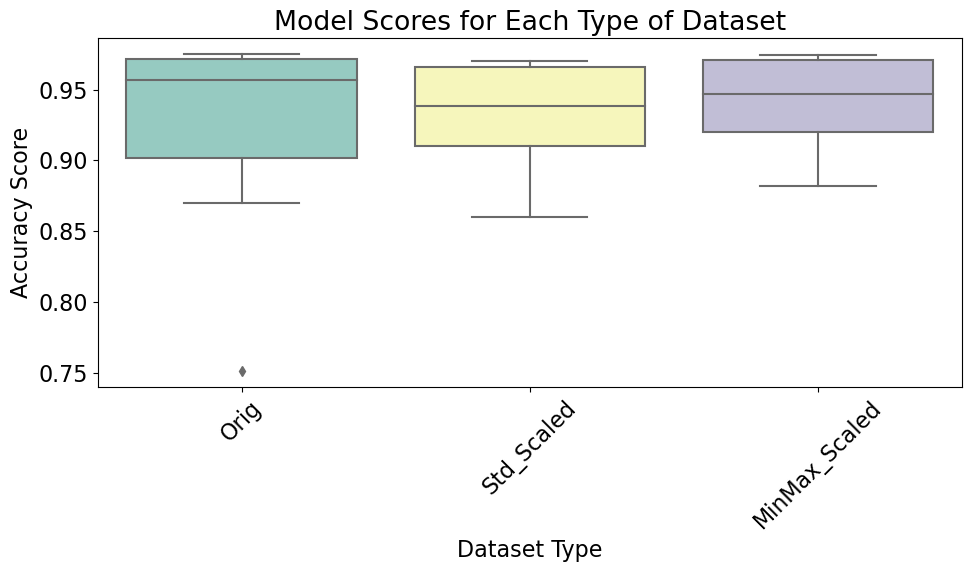

In [595]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_scores, palette="Set3")
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The outlier GaussianNB hide detailed ticks on the Y-axis, so let's drop them as well:

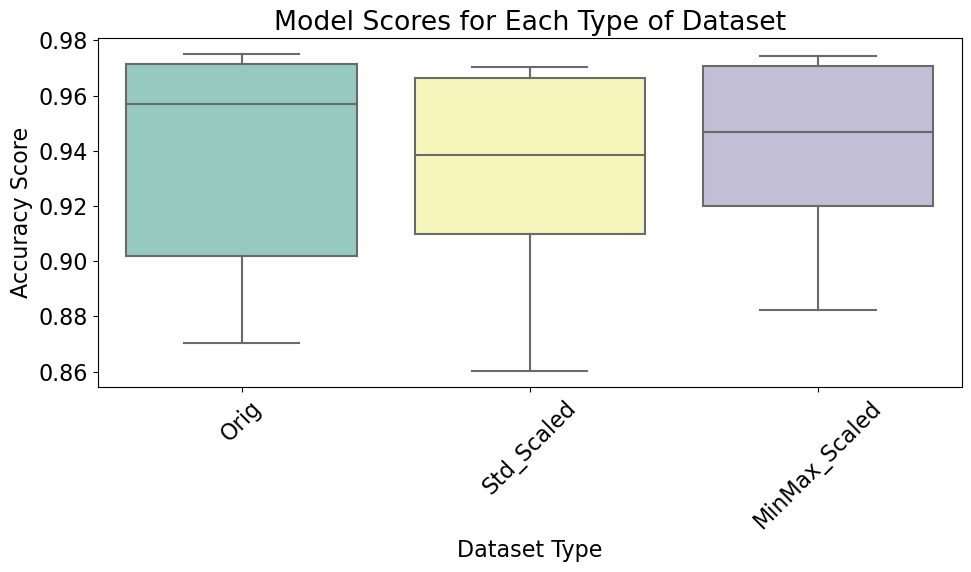

In [596]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_scores, palette="Set3", showfliers=False)
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we can see that MinMaxScaler helped models get better score. The IQR of its boxplot is smaller then orig.

Overall, almost all models have accuracy higher then 86%, which is good result!

But we can do better dropping pixels that have no usefull info - that means we need to do feature selection.

### PCA

**Principal Component Analysis (PCA)** is a dimensionality reduction technique used in machine learning and data analysis. It aims to reduce the dimensionality of a dataset while preserving most of the variability or information present in the original data. PCA achieves this by transforming the original features into a new set of uncorrelated features called principal components.
* PCA finds linear subspaces which best represent your data, trying to minimize sum of squares of error norms and maximize variance of projected points.

* These components may be more informative or less noisy than the original features.

PCA can help address multicollinearity issues in the dataset by transforming correlated variables into orthogonal principal components. These components are uncorrelated with each other, meaning that multicollinearity among the original predictors is reduced or eliminated in the transformed space.

#### Orig + PCA

Let's fit PCA and see how much components explain 95% of total variance:

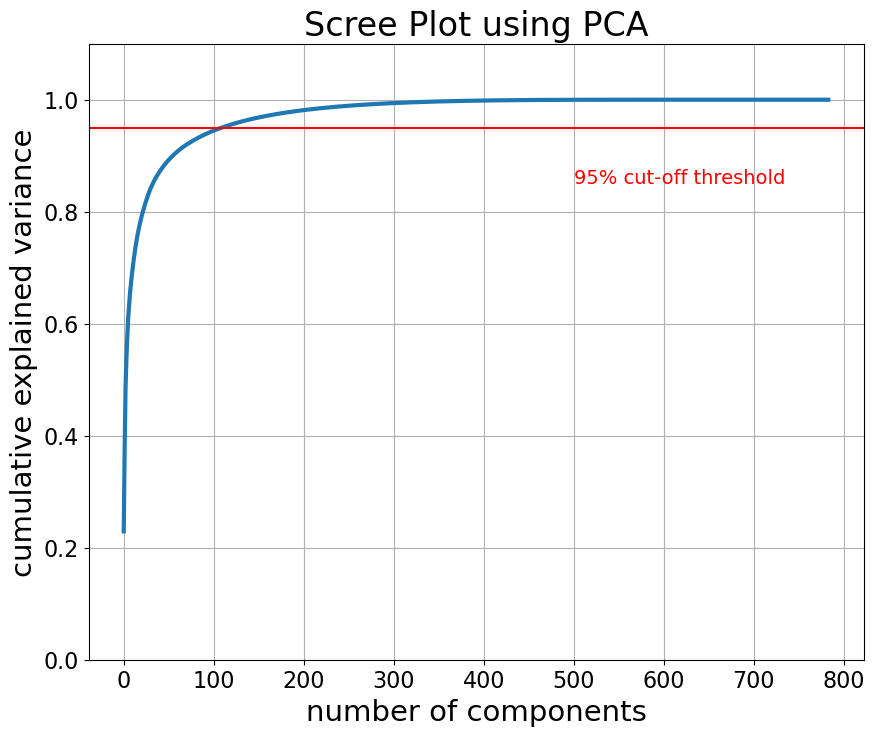

Number of components at intersection: 110


In [597]:
pca = PCA()
Xtrain_pca = pca.fit_transform(Xtrain)

plt.figure(figsize=(10,8))
plt.ylim(0.0,1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(500, 0.85, '95% cut-off threshold', color = 'red', fontsize=14)
plt.xlabel('number of components', fontsize=21)
plt.ylabel('cumulative explained variance', fontsize=21)
plt.title('Scree Plot using PCA', fontsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('font', size=16)
plt.rc('ytick', labelsize=16)
plt.grid()
plt.show()

intersection_index = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0]
num_components_at_intersection = intersection_index + 1 
print("Number of components at intersection:", num_components_at_intersection)

We have optimal number of components - 110:

In [598]:
pca = PCA(n_components=110)
Xtrain_pca = pca.fit_transform(Xtrain)

print('Dimensions of transformed data:', Xtrain_pca.shape)
print('Dimensions of the original data:', Xtrain.shape)
print('Proportion of variance explained:', "%.3f" % np.sum(pca.explained_variance_ratio_))

Dimensions of transformed data: (1680, 110)
Dimensions of the original data: (1680, 784)
Proportion of variance explained: 0.950


Let's try to plot images after PCA:

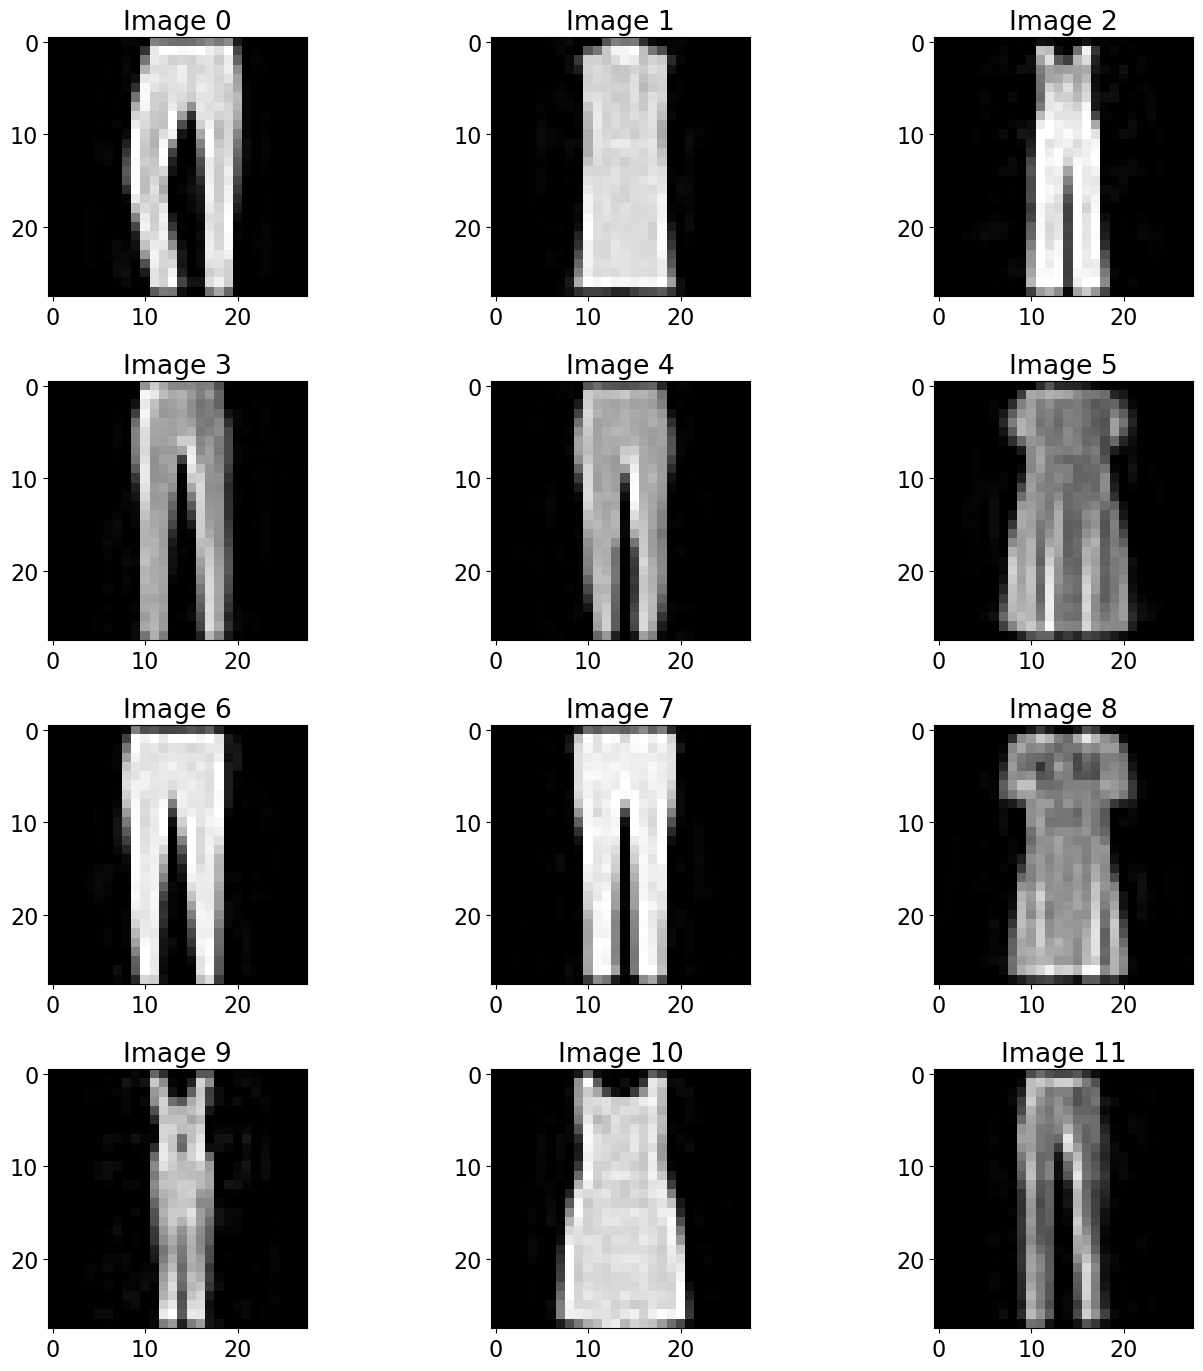

RMSE: 10.389978138596112


In [599]:
# Reconstruct images from principal components
reconstructed_images = pca.inverse_transform(Xtrain_pca)

# Number of images to display
num_images = 12 

# Calculate the number of rows and columns for subplots
num_rows = (num_images + 2) // 3  # Ensure at least 3 images per row
num_cols = min(num_images, 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

# Let's plot several reconstructed images on separate subplots
for img_index in range(num_images):
    img = reconstructed_images[img_index].reshape((28,28))
    row_index = img_index // num_cols
    col_index = img_index % num_cols
    axes[row_index,col_index].imshow(img, cmap='gray',vmin=0,vmax=255)
    axes[row_index,col_index].set_title(f'Image {img_index}')  # Add title to each subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
print('RMSE:', metrics.mean_squared_error(Xtrain, reconstructed_images, squared = False))

- The average reconstruction error is about 10, which is the same as if the grayscale value in each pixel differed by 10 in the average case.

Now it is time to train ~~the dragon~~ our models:

In [600]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [601]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Orig_PCA'] = scores
model_hparams['Orig_PCA'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA
Model,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952
SVC (RBF),0.975000,0.968452,0.974405,0.976786
SVC (Sigm),0.970833,0.965476,0.969643,0.970238
GaussianNB,0.751190,0.905952,0.925595,0.863690
BernoulliNB,0.945238,0.911310,0.922619,0.887500
LDA (LSQR),0.968452,0.964286,0.967857,0.969643
LDA (SVD),0.912500,0.912500,0.912500,0.969048
QDA,0.870238,0.860119,0.882143,0.962500


- Here we can see improvement in model's scores. Feature selection allowed then to concetrate on important correlations and most significant variations in the data.
- Specifically, QDA now have significantly bigger accuracy of 96.25%, which proves PCA ability to reduce multicollinearity among the original data.

#### Orig + PCA + Standart Scaled

The variance among the PCA components could be of the different order of magnitude. Therefore it is good idea to standartize values:

In [602]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {
      'after_scale':[StandardScaler()]
}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [603]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Orig_PCA_Std_Scaled'] = scores
model_hparams['Orig_PCA_Std_Scaled'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled
Model,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048
QDA,0.870238,0.860119,0.882143,0.962500,0.961905


- IN this case, standartizing data has done little to improve the model. Let's try MinMaxScaler instead.

#### Orig + PCA + MinMax scaled

In [604]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {
      'after_scale':[MinMaxScaler()]
}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [605]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Orig_PCA_MinMax_Scaled'] = scores
model_hparams['Orig_PCA_MinMax_Scaled'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled
Model,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881


- Again, applying scaler was not a good idea. the most noticeable difference you can see in accuracy of BenoulliNB - it has dropped to a coin flip.

#### Visualization

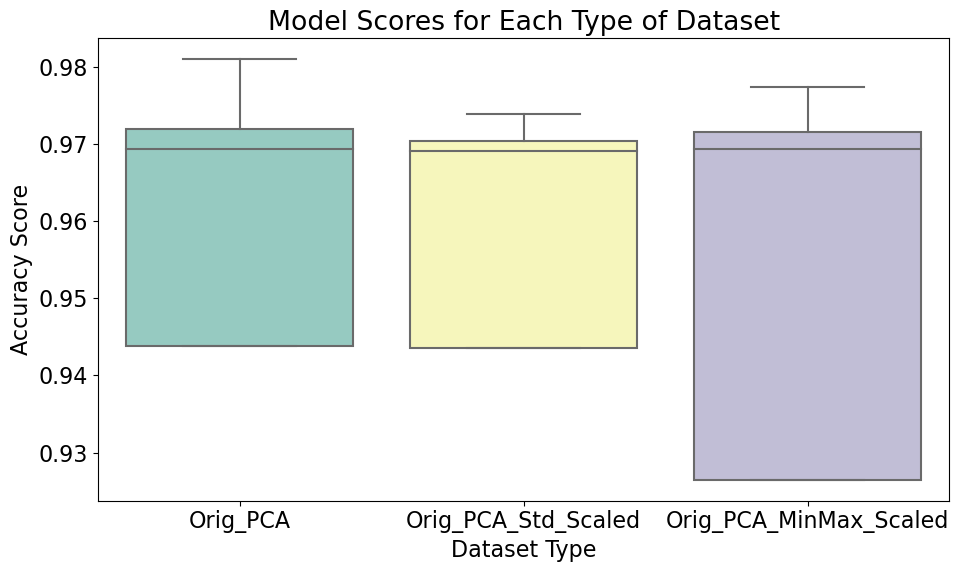

In [606]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_scores[["Orig_PCA", "Orig_PCA_Std_Scaled", "Orig_PCA_MinMax_Scaled"]], palette="Set3",showfliers=False)
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Not using StandartScale after PCA yields better accuracy for models.

#### Standart Scaled + PCA

Centering the data before performing PCA is essential to ensure that each feature contributes equally to the principal components. Without it, features with larger scales may influence the principal components disproportionately.

In [607]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[StandardScaler()],
      'before_scale__with_std':[True,False]
}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [608]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Std_Scaled_PCA'] = scores
model_hparams['Std_Scaled_PCA'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA
Model,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500


- Perfect demonstration of neccesity of applyin centering to dataset before PCA: although we did not break the record for accuracy, all models now have better accuracy among datasets where PCA was applied 

#### Standart Scaled + PCA + Standart Scaled

What if we apply StandartScaler now?

In [609]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[StandardScaler()],
      'before_scale__with_std':[True,False]
}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {
      'after_scale':[StandardScaler()]
}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [610]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Std_Scaled_PCA_Std_Scaled'] = scores
model_hparams['Std_Scaled_PCA_Std_Scaled'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA,Std_Scaled_PCA_Std_Scaled
Model,,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952,0.969048
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595,0.975000
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238,0.970833
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690,0.810714
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214,0.895833
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643,0.969643
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238,0.969643
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500,0.961905


- Once again, not my brightest idea. The accuracy has either left unchanged or decreased by few thousandth. 

#### MinMax Scaled + PCA

What if instead of centering we will use alternative - MinMaxScaler?

In [611]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[MinMaxScaler()]
}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [612]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['MinMax_Scaled_PCA'] = scores
model_hparams['MinMax_Scaled_PCA'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA,Std_Scaled_PCA_Std_Scaled,MinMax_Scaled_PCA
Model,,,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952,0.969048,0.979167
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595,0.975000,0.976190
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238,0.970833,0.970833
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690,0.810714,0.864881
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214,0.895833,0.880357
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643,0.969643,0.969048
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238,0.969643,0.969048
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500,0.961905,0.967262


- Using MinMax gives us slightly worse results rather then centering data 

#### MinMax Scaled + PCA + MinMax Scaled

In [613]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[MinMaxScaler()]
}
dim_reduction = {
      'reduce_dim':[PCA()],
      'reduce_dim__n_components':[110]
}
scaler_after = {
      'after_scale':[MinMaxScaler()]
}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

In [614]:
scores_scaled = [results[model]['best_score'] for model in model_scores.index]
params_scaled = [results[model]['best_params'] for model in model_scores.index]
model_scores['MinMax_Scaled_PCA_MinMax_Scaled'] = scores_scaled
model_hparams['MinMax_Scaled_PCA_MinMax_Scaled'] = params_scaled
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA,Std_Scaled_PCA_Std_Scaled,MinMax_Scaled_PCA,MinMax_Scaled_PCA_MinMax_Scaled
Model,,,,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952,0.969048,0.979167,0.973810
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595,0.975000,0.976190,0.975000
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238,0.970833,0.970833,0.969048
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690,0.810714,0.864881,0.807738
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214,0.895833,0.880357,0.539881
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643,0.969643,0.969048,0.969048
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238,0.969643,0.969048,0.969643
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500,0.961905,0.967262,0.964881


- The effect of applying MinMaxScaler twice is the same as applying StandartScaler
- **Interesting moment**: Models LDA and QDA have same accuracies, no matter of scaler applied or not applied.
  - Since PCA is based solely on the variance of the data, scaling does not affect the principal components themselves, only their scaling.
  - Since LDA operates on the covariance matrix of the classes, the relative positions and distributions of the classes remain the same regardless of scaling.
  - LDA focuses on the relative distances and distributions of the classes in the feature space, rather than the absolute scale of the features. 

Therefore, applying scaling after PCA does not affect the classification accuracy of LDA and QDA.

#### Visualization

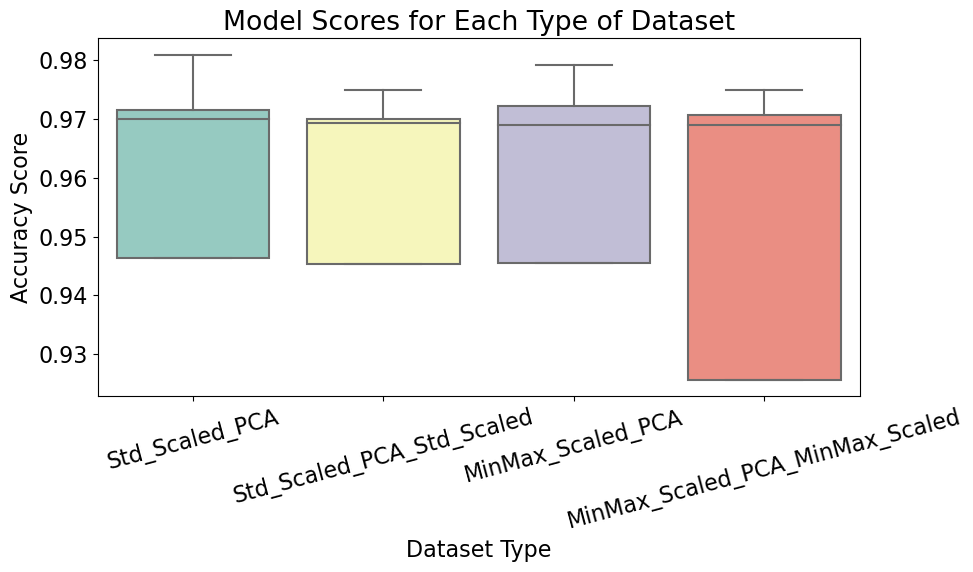

In [615]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_scores[["Std_Scaled_PCA", "Std_Scaled_PCA_Std_Scaled", "MinMax_Scaled_PCA","MinMax_Scaled_PCA_MinMax_Scaled"]], palette="Set3",showfliers=False)
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Clearly, scaling after applying PCA on scaled datasets has no meaning - the results has lower scores.

Let's compare results of applying scaler before PCA: 

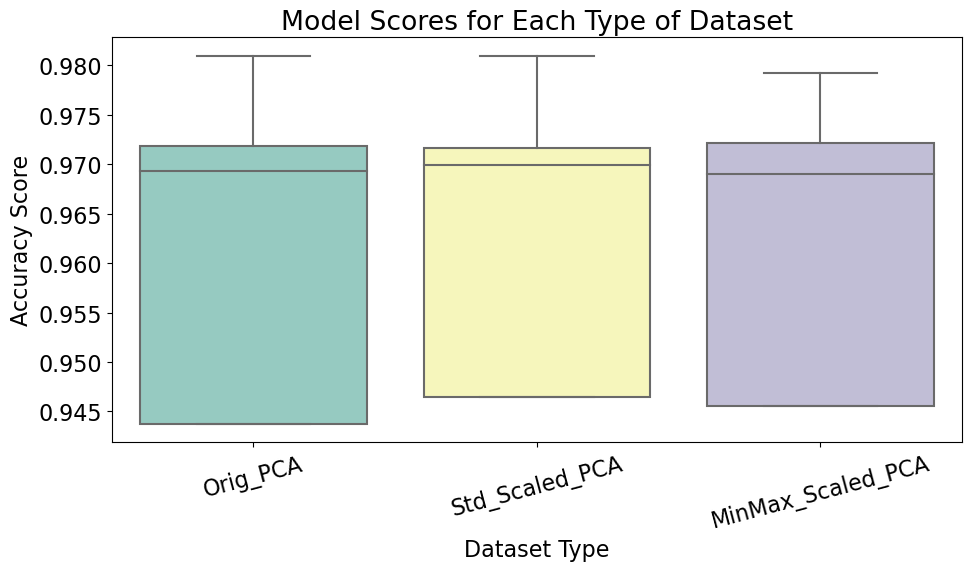

In [621]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_scores[["Orig_PCA", "Std_Scaled_PCA", "MinMax_Scaled_PCA"]], palette="Set3",showfliers=False)
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### LLE

Locally Linear Embedding (LLE) is a nonlinear dimensionality reduction technique used for finding low-dimensional embeddings of high-dimensional data. It observes how individual training points depend linearly on their surroundings and then searches for a less dimensional representation that preserves these local constraints.

#### Orig + LLE

In [634]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {}
dim_reduction = {
      'reduce_dim':[LocallyLinearEmbedding()],
      'reduce_dim__n_neighbors': range(5,16,5),
      'reduce_dim__n_components': range(90,111,10),
      'reduce_dim__method': ['standard']
}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

Fitting 5 folds for each of 1764 candidates, totalling 8820 fits


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(LocallyLinearEmbedding(n_components=90, n_neighbors=10),       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
2217       0       0       0       0       0       0       0       0       2   
1160       0       0       0       0       0       0       0       0       0   
906        0       0       0       0       0       0       0       0       0   
660        0       0       0       0       0       0       0       0       0   
1499       0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
938        0       0       0       0       0       0       0       0       0   
1773       0       0       0       0       0       0       0..., 
2217    0
1160    1
906     0
660     0
1499    0
       ..
938     1
1773    0
9

In [635]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Orig_LLE'] = scores
model_hparams['Orig_LLE'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df   

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA,Std_Scaled_PCA_Std_Scaled,MinMax_Scaled_PCA,MinMax_Scaled_PCA_MinMax_Scaled,Orig_LLE
Model,,,,,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952,0.969048,0.979167,0.973810,0.967857
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595,0.975000,0.976190,0.975000,0.971429
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238,0.970833,0.970833,0.969048,0.970238
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690,0.810714,0.864881,0.807738,0.960119
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214,0.895833,0.880357,0.539881,0.959524
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643,0.969643,0.969048,0.969048,0.969643
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238,0.969643,0.969048,0.969643,0.969643
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500,0.961905,0.967262,0.964881,0.971429


- LLE requires much more time to compute. It is because we are tuning several hyperparameters
- Effect of scalers, applied after feature selection methods, were negligible - therefore we are going to try to scale only before applying LLE

#### Standart Scaled + LLE

In [636]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[StandardScaler()]
}
dim_reduction = {
      'reduce_dim':[LocallyLinearEmbedding()],
      'reduce_dim__n_neighbors': range(5,16,5),
      'reduce_dim__n_components': range(90,111,10),
      'reduce_dim__method': ['standard']
}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

Fitting 5 folds for each of 1764 candidates, totalling 8820 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(),       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
2217       0       0       0       0       0       0       0       0       2   
1160       0       0       0       0       0       0       0       0       0   
906        0       0       0       0       0       0       0       0       0   
660        0       0       0       0       0       0       0       0       0   
1499       0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
938        0       0       0       0       0       0       0       0       0   
1773       0       0       0       0       0       0       0..., 
2217    0
1160    1
906     0
660     0
1499    0
     

In [637]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['Std_Scaled_LLE'] = scores
model_hparams['Std_Scaled_LLE'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df 

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA,Std_Scaled_PCA_Std_Scaled,MinMax_Scaled_PCA,MinMax_Scaled_PCA_MinMax_Scaled,Orig_LLE,Std_Scaled_LLE
Model,,,,,,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952,0.969048,0.979167,0.973810,0.967857,0.960714
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595,0.975000,0.976190,0.975000,0.971429,0.966667
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238,0.970833,0.970833,0.969048,0.970238,0.969048
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690,0.810714,0.864881,0.807738,0.960119,0.955952
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214,0.895833,0.880357,0.539881,0.959524,0.948214
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643,0.969643,0.969048,0.969048,0.969643,0.962500
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238,0.969643,0.969048,0.969643,0.969643,0.961310
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500,0.961905,0.967262,0.964881,0.971429,0.960714


#### MinMax Scaled + LLE

In [638]:
# ("before_scale", "passthrough"),
# ("reduce_dim", "passthrough"),
# ("after_scale", "passthrough"),

scaler_before = {
      'before_scale':[MinMaxScaler()]
}
dim_reduction = {
      'reduce_dim':[LocallyLinearEmbedding()],
      'reduce_dim__n_neighbors': range(5,16,5),
      'reduce_dim__n_components': range(90,111,10),
      'reduce_dim__method': ['standard']
}
scaler_after = {}

results = train_multiple_models(X_train=Xtrain,y_train=ytrain,scaler_before=scaler_before,dim_reduction=dim_reduction,scaler_after=scaler_after)

Fitting 5 folds for each of 1764 candidates, totalling 8820 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(MinMaxScaler(),       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
2217       0       0       0       0       0       0       0       0       2   
1160       0       0       0       0       0       0       0       0       0   
906        0       0       0       0       0       0       0       0       0   
660        0       0       0       0       0       0       0       0       0   
1499       0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
938        0       0       0       0       0       0       0       0       0   
1773       0       0       0       0       0       0       0..., 
2217    0
1160    1
906     0
660     0
1499    0
       

In [639]:
scores = [results[model]['best_score'] for model in model_scores.index]
params = [results[model]['best_params'] for model in model_scores.index]
model_scores['MinMax_Scaled_LLE'] = scores
model_hparams['MinMax_Scaled_LLE'] = params
styled_df = model_scores.style.apply(highlight_max)
styled_df 

,Orig,Std_Scaled,MinMax_Scaled,Orig_PCA,Orig_PCA_Std_Scaled,Orig_PCA_MinMax_Scaled,Std_Scaled_PCA,Std_Scaled_PCA_Std_Scaled,MinMax_Scaled_PCA,MinMax_Scaled_PCA_MinMax_Scaled,Orig_LLE,Std_Scaled_LLE,MinMax_Scaled_LLE
Model,,,,,,,,,,,,,
SVC (Poly),0.973810,0.970238,0.973810,0.980952,0.969048,0.975595,0.980952,0.969048,0.979167,0.973810,0.967857,0.960714,0.965476
SVC (RBF),0.975000,0.968452,0.974405,0.976786,0.973810,0.977381,0.975595,0.975000,0.976190,0.975000,0.971429,0.966667,0.969643
SVC (Sigm),0.970833,0.965476,0.969643,0.970238,0.970833,0.969643,0.970238,0.970833,0.970833,0.969048,0.970238,0.969048,0.969643
GaussianNB,0.751190,0.905952,0.925595,0.863690,0.811310,0.811310,0.863690,0.810714,0.864881,0.807738,0.960119,0.955952,0.959524
BernoulliNB,0.945238,0.911310,0.922619,0.887500,0.888690,0.547024,0.898214,0.895833,0.880357,0.539881,0.959524,0.948214,0.960119
LDA (LSQR),0.968452,0.964286,0.967857,0.969643,0.970238,0.970238,0.969643,0.969643,0.969048,0.969048,0.969643,0.962500,0.970238
LDA (SVD),0.912500,0.912500,0.912500,0.969048,0.969048,0.969048,0.970238,0.969643,0.969048,0.969643,0.969643,0.961310,0.969643
QDA,0.870238,0.860119,0.882143,0.962500,0.961905,0.964881,0.962500,0.961905,0.967262,0.964881,0.971429,0.960714,0.970238


#### Visualization

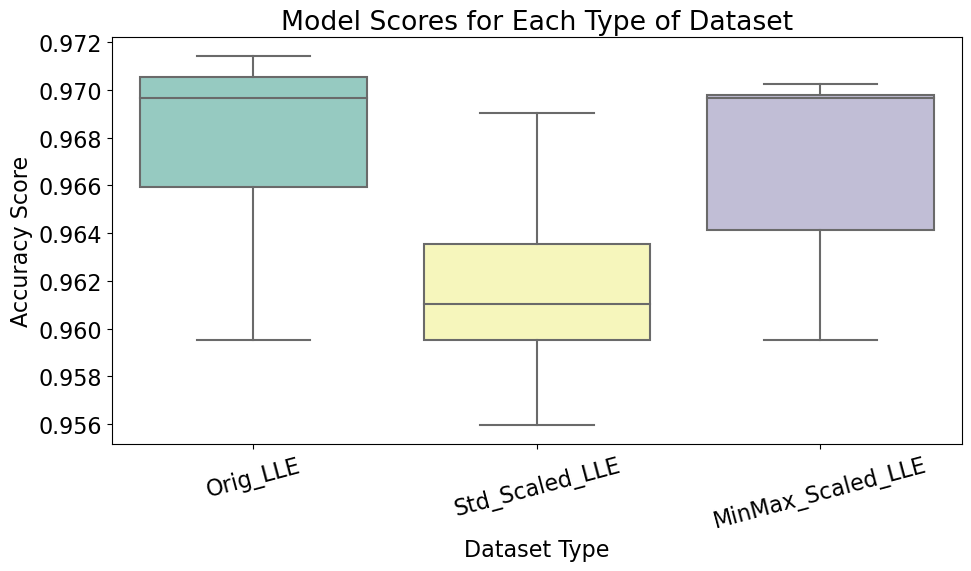

In [640]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=model_scores[["Orig_LLE", "Std_Scaled_LLE", "MinMax_Scaled_LLE"]], palette="Set3",showfliers=False)
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Suddenly, using StandartScaler or MinMaxScaler makes model's performances worsen. 
- The highest score using LLE did not exceeded best score of PCA. Therefore, we can begin choosing best model

## Final Model

### Choosing final model

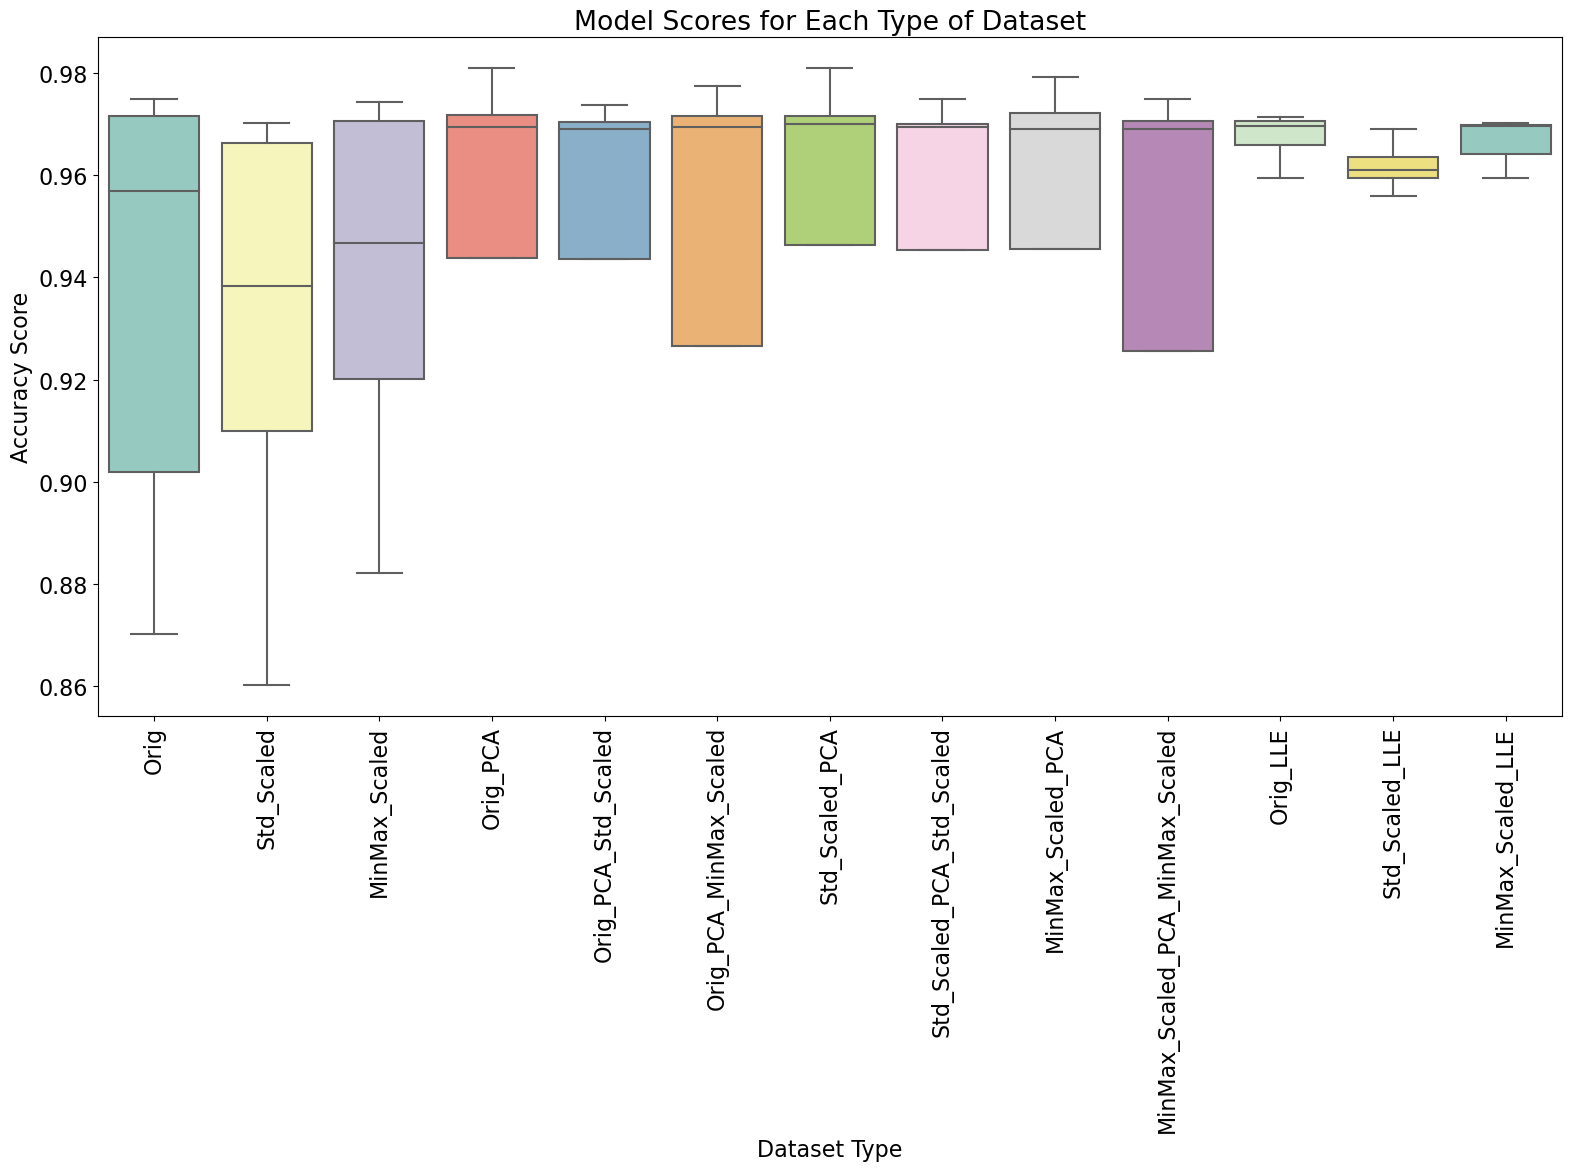

In [641]:
plt.figure(figsize=(16, 12))
sns.boxplot(data=model_scores, palette="Set3",showfliers=False)
plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

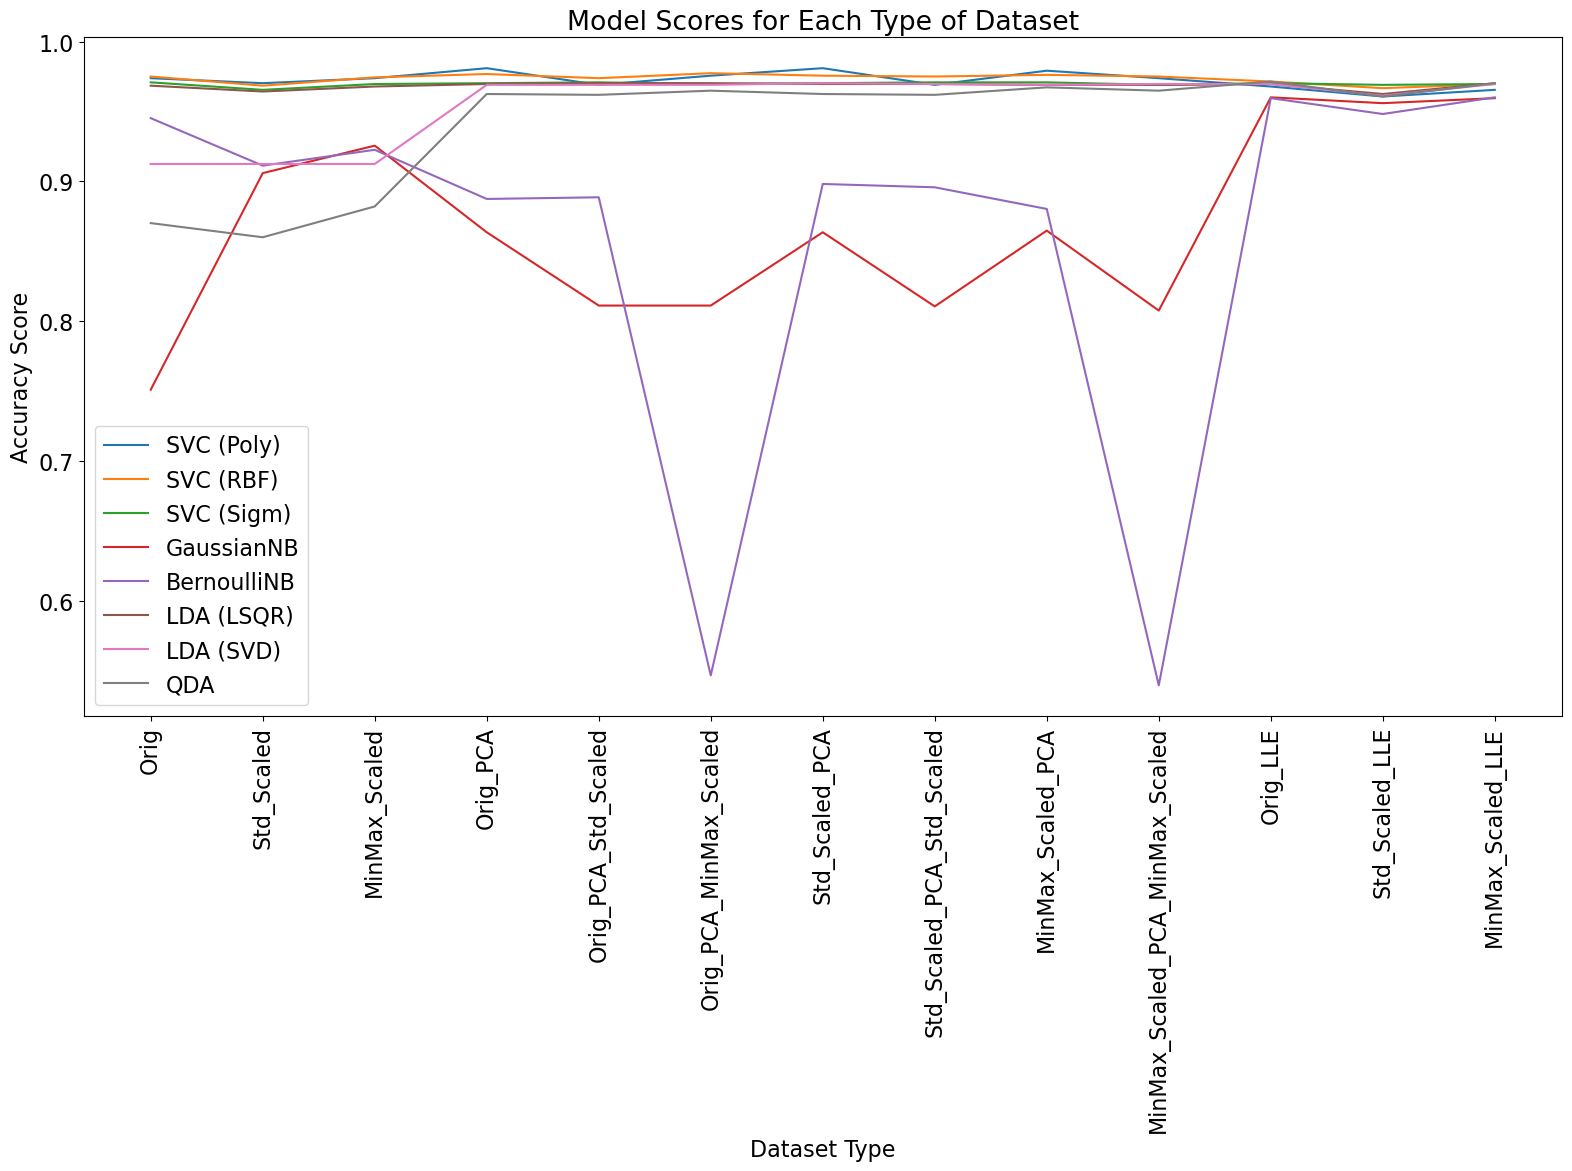

In [642]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# Plot lines for each model's scores
for model_name in model_scores.index:
    plt.plot(range(len(model_scores.columns)), model_scores.loc[model_name], label=model_name)

plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.legend()
plt.xticks(range(len(model_scores.columns)), model_scores.columns, rotation=90)
plt.tight_layout()
plt.show()


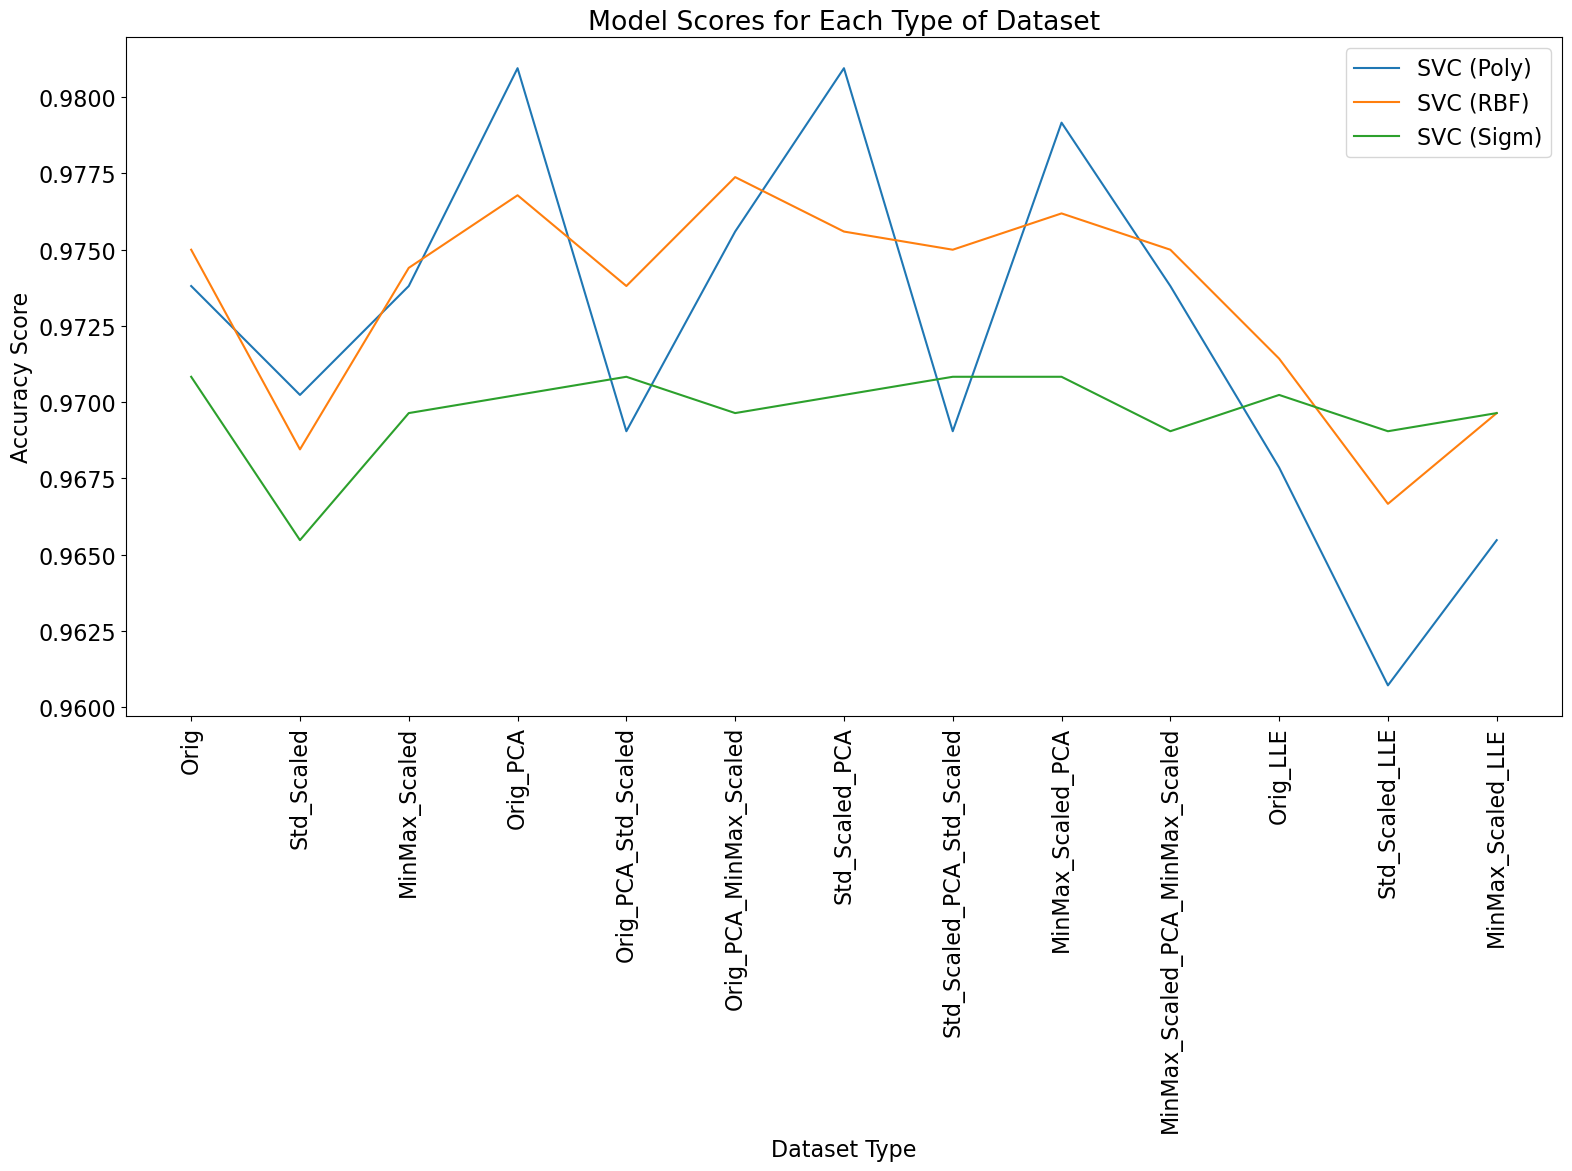

In [643]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

# Select only the rows for SVC (Poly), SVC (RBF), and SVC (Sigmoid)
selected_models = model_scores.loc[["SVC (Poly)", "SVC (RBF)", "SVC (Sigm)"]]

# Plot lines for each model's scores
for model_name in selected_models.index:
    plt.plot(range(len(selected_models.columns)), selected_models.loc[model_name], label=model_name)

plt.title("Model Scores for Each Type of Dataset")
plt.xlabel("Dataset Type")
plt.ylabel("Accuracy Score")
plt.legend()
plt.xticks(range(len(selected_models.columns)), selected_models.columns, rotation=90)
plt.tight_layout()
plt.show()


In [645]:
model_scores.loc["SVC (Poly)","Orig_PCA"] ==model_scores.loc["SVC (Poly)","Std_Scaled_PCA"]

True

- Best model - **SVC (Poly)**
- Dataset: **Orig + PCA** OR **StandartScaler + PCA**
  - Both datasets have the best accuracy, but centering data before PCA is vital for accurate components selection and accurate predictions

### Training PCA for final model

In [646]:
model_hparams.loc['SVC (Poly)','Std_Scaled_PCA']

{'before_scale': StandardScaler(with_std=False),
 'before_scale__with_std': False,
 'clf__C': 10.0,
 'clf__degree': 3,
 'clf__gamma': 0.01,
 'clf__kernel': 'poly',
 'clf__max_iter': 1000000,
 'reduce_dim': PCA(n_components=110),
 'reduce_dim__n_components': 110}

Let's try tuning more precisely:

In [670]:
results = {}
memory = Memory(location="./cache",verbose=0)

pipe_poly = Pipeline(
    [
        ("before_scale", "passthrough"),
        ("reduce_dim", "passthrough"),
        ("clf", SVC(cache_size=1999)),
    ],
    memory=memory
)
param_grid_poly = params = {
    'before_scale': [StandardScaler(with_std=False)],
    'before_scale__with_std': [False],
    'clf__C': [10.0],
    'clf__degree': [3],
    'clf__gamma': [0.01],
    'clf__kernel': ['poly'],
    'clf__probability':[True],
    'reduce_dim': [PCA()],
    'reduce_dim__n_components': range(80,121)
}

grid_search_poly = GridSearchCV(estimator=pipe_poly, param_grid=param_grid_poly, cv=5, scoring='accuracy',n_jobs=-1,verbose=2,refit=['reduce_dim', 'clf'])
grid_search_poly.fit(Xtrain, ytrain)

best_params_poly = grid_search_poly.best_params_
best_score_poly = grid_search_poly.best_score_
print(f"We found the best params for poly kernel {best_params_poly}\nWith cross-validation accuracy {best_score_poly:.5f}.")
memory.clear(warn=False)

Fitting 5 folds for each of 41 candidates, totalling 205 fits


We found the best params for poly kernel {'before_scale': StandardScaler(with_std=False), 'before_scale__with_std': False, 'clf__C': 10.0, 'clf__degree': 3, 'clf__gamma': 0.01, 'clf__kernel': 'poly', 'clf__probability': True, 'reduce_dim': PCA(n_components=98), 'reduce_dim__n_components': 98}
With cross-validation accuracy 0.98095.


Indeed, we have slightly more accuracy after experimenting with number of dimensions for PCA.

### Final model

In [690]:
final_model = grid_search_poly.best_estimator_

# Accuracy Estimate
print(f"Accuracy estimate for final model is {metrics.accuracy_score(ytest,final_model.predict(Xtest)):.5f}")

Accuracy estimate for final model is 0.98472


## Model evaluation

### Confusion matrix

- The confusion matrix provides insight into the true positives, false positives, true negatives, and false negatives, which are fundamental for evaluating the performance of a classification model.

**Values and Formulas**

The Confusion Matrix is a 2x2 matrix with the following elements:

[[TP, FP],

[FN, TN]]

In [681]:
# Predictions from the final model
y_pred = final_model.predict(Xtest)

# Generate the confusion matrix
cm = metrics.confusion_matrix(ytest, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[344  10]
 [  1 365]]


Analyzing the matrix, we can conclude that our model are good at predicting True Negatives (Trousers, in our case, see Data Exploration) and slightly worse at predicting True Positives (Non-Trousers).

Almost all metrics are based on values from confusion matrix:

- **Accuracy**: $$ \frac{TP + TN}{TP + TN + FP + FN} $$
- **Precision**: $$ \frac{TP}{TP + FP} $$
- **Recall (Sensitivity)**: $$ \frac{TP}{TP + FN} $$
- **Specificity**: $$ \frac{TN}{TN + FP} $$
- **F1 Score**: $$ \frac{2 \times (Precision \times Recall)}{Precision + Recall} $$

Let's use some of them:

### Precision score

Precision is a metric that evaluates the accuracy of positive predictions made by the model. It measures the proportion of true positive predictions among all instances that were predicted as positive by the model.

**Relevance**

- Precision is essential because it provides insights into the reliability of positive predictions made by the model. It is particularly relevant in situations where the cost of false positives is high, and we want to minimize the number of incorrect positive predictions. 
- In our case of predicting whether an image is a picture of trousers or not, precision would help ensure that the model correctly identifies trousers images while minimizing false alarms. This would be particularly important if false alarms (misidentifying non-trousers images as trousers) are costly or undesirable.

In [682]:
# Calculate precision score for the final model
precision = metrics.precision_score(ytest, y_pred)

print(f"Precision Score: {precision:.5f}")

Precision Score: 0.97333


### Recall score

The Recall Score evaluates the model's ability to correctly identify positive instances out of all actual positive instances in the dataset.

**Relevance**

Recall is crucial when the cost of false negatives is high, such as in medical diagnoses or predictive maintenance. It helps us understand how effectively the model identifies positive instances from the total number of actual positive instances.

A high recall score indicates that the model can effectively identify positive instances, minimizing the number of instances incorrectly labeled as negative. Conversely, a low recall score suggests that the model may miss positive instances, leading to more false negatives.

In [683]:
# Calculate recall score for the final model
recall = metrics.recall_score(ytest, y_pred)

print(f"Recall Score: {recall:.5f}")

Recall Score: 0.99727


### ROC AUC

The ROC curve is a graphical representation that illustrates the performance of a binary classification model across different thresholds. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

**Relevance**

The ROC curve is particularly useful for evaluating binary classification models when the classes are imbalanced or when the cost of false positives and false negatives differs. It provides a comprehensive overview of the trade-off between true positive rate and false positive rate across different threshold settings.

**Values and Formulas**

- True Positive Rate (TPR): $$ \frac{TP}{TP + FN} $$
- False Positive Rate (FPR): $$ \frac{FP}{FP + TN} $$

#### ROC AUC Score

The Receiver Operating Characteristic Area Under the Curve (ROC AUC) score is a metric used to evaluate the performance of a binary classification model. It quantifies the ability of the model to distinguish between the positive and negative classes by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

**Why use it:**
- ROC AUC provides a comprehensive assessment of the classifier's performance across all possible classification thresholds, making it robust to class imbalance.
- It evaluates the model's ability to rank true positives higher than false positives across different decision thresholds.

**Values and Interpretation:**
- The ROC AUC score ranges from 0 to 1, where:
  - A score of 1 indicates a perfect classifier that separates all positive and negative instances perfectly.
  - A score of 0.5 suggests a classifier that performs no better than random guessing.
  - Scores between 0.5 and 1 indicate better-than-random classification performance, with higher values indicating better performance.

**Formulas:**
- The ROC AUC score is calculated by computing the area under the ROC curve.

**Comparisons to our case with trousers:**
In the context where class 0 represents trousers and class 1 represents non-trousers, a high ROC AUC score indicates that the model effectively distinguishes between images containing trousers (class 0) and those not containing trousers (class 1).

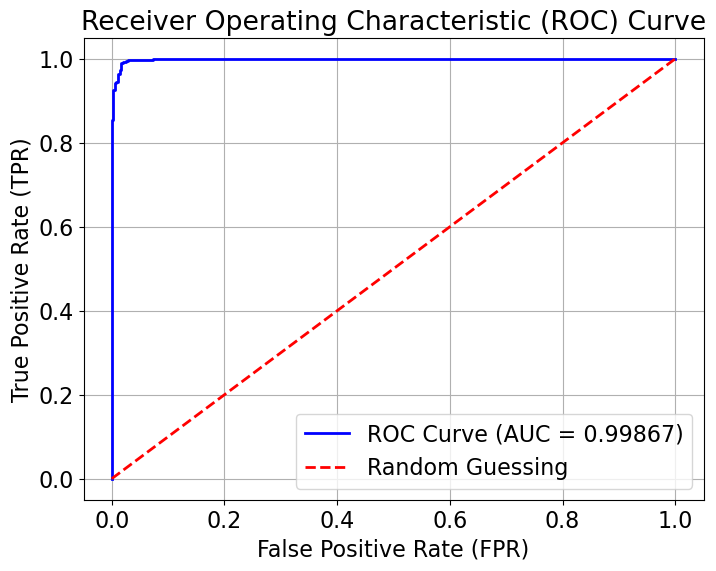

In [684]:
# Calculate probabilities for positive class
y_probs = final_model.predict_proba(Xtest)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(ytest, y_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC curve looks beautiful, and AUC score is high, indicating that the model has a strong ability to rank trousers images higher than non-trousers images.

### <img src="https://i.imgflip.com/4ke5lg.png" width=294px height=300px />
We can also use some alternative methods and metrics:

### Cohen's Kappa Score

Cohen's Kappa is a statistic that measures the level of agreement between two raters who classify items into mutually exclusive categories. In the context of classification models, Cohen's Kappa is used to evaluate the agreement between the predicted labels and the true labels, considering the possibility of agreement occurring by chance.

**Why to use**

Cohen's Kappa is particularly useful when dealing with imbalanced datasets or datasets where the classes are not equally represented. It takes into account the possibility of agreement occurring by chance and provides a more robust measure of classification performance compared to simple accuracy.

**Formula**

Cohen's Kappa is calculated using the formula:

$$ \kappa = \frac{{p_o - p_e}}{{1 - p_e}} $$

Where:
- $ p_o $ is the observed agreement, which is the proportion of instances where the raters (or the classifier and the true labels) agree.
- $ p_e $ is the expected agreement, which is the proportion of instances where agreement is expected to occur by chance.

The values of Cohen's Kappa range from -1 to 1:
- A Kappa value of 1 indicates perfect agreement between the raters or classifier and true labels.
- A Kappa value of 0 indicates agreement equivalent to that expected by chance alone.
- A Kappa value less than 0 suggests systematic disagreement.

**Our Case**

In the context of classifying trousers versus non-trousers images, Cohen's Kappa Score would assess the agreement between the model's predictions and the true labels. It provides insight into how well the model performs compared to random chance, considering the balance between true positives, true negatives, false positives, and false negatives.

In [686]:
# Calculate Cohen's Kappa Score
kappa_score = metrics.cohen_kappa_score(ytest, y_pred)

print(f"Cohen's Kappa Score:{kappa_score:.5f}")

Cohen's Kappa Score:0.96942


This metric's value is very close to 1, which means that two raters (SVM and true values) are coexicting in peace and prosperity

The last metric:

### Matthews Correlation Coefficient (MCC)

Matthews Correlation Coefficient (MCC) is a metric used to evaluate the performance of binary classification models. It takes into account true positives, true negatives, false positives, and false negatives to provide a balanced measure of classification performance.

**Why to use**

MCC provides a balanced measure of classification performance, taking into account both sensitivity (true positive rate) and specificity (true negative rate). It is considered better metric rather then F1-score and accuracy: https://en.wikipedia.org/wiki/Phi_coefficient#Advantages_over_accuracy_and_F1_score

#### Formula and Interpretation

Matthews Correlation Coefficient is calculated using the following formula:

$$ MCC = \frac{{TP \times TN - FP \times FN}}{{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}} $$

Where:
- $ TP $ is the number of true positives.
- $ TN $ is the number of true negatives.
- $ FP $ is the number of false positives.
- $ FN $ is the number of false negatives.

The values of MCC range from -1 to 1:
- A MCC value of 1 indicates perfect classification performance.
- A MCC value of -1 indicates perfect inverse classification performance.
- A MCC value of 0 indicates no better than random classification performance.

In [687]:
# Calculate Matthews Correlation Coefficient
mcc = metrics.matthews_corrcoef(ytest, y_pred)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.5f}")

Matthews Correlation Coefficient (MCC): 0.96973
